# MIMIC-CXR Dataset Sampling Analysis

## Dataset Overview
We randomly sample **1,000 reports** from **MIMIC-CXR** 

## Multi-Label Classification Problem
Each sampled report is associated with **multiple disease labels**, forming a classic **multi-label classification** task:

- A single report may involve several co-occurring diseases or abnormalities (e.g., pneumonia, cardiomegaly).
- Labels can be **positive** (present), **negative** (absent), or **uncertain**.

## RadGraph Entity Extraction
To enhance structure in the textual data, we use **RadGraph** to extract entities and relationships from reports. We focus on the following **four entity types**:

- **Anatomy**: Anatomical structures involved (e.g., lungs, heart, bones).
- **Finding — Present**: Clearly observed abnormalities or features (e.g., “pulmonary infiltrate”).
- **Finding — Absent**: Explicitly ruled-out abnormalities (e.g., “no evidence of pneumonia”).
- **Finding — Uncertain**: Ambiguous or possible observations (e.g., “suspected lung shadow”).


## Data Analysis Part

We do analysis on the following parts:
1. The caption (corresponding to the report).
2. Preprocessed version with Radgraph.
3. Extracted entities.

Each Analysis is focus on the min/medium/max length of text, as well as the word frequency including the common words (descriptive) and anatomical words. 

In [19]:
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter, defaultdict
import re
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Set style for better plots
try:
    plt.style.use('seaborn-v0_8-whitegrid')
    print("Using seaborn-v0_8-whitegrid style")
except:
    try:
        plt.style.use('seaborn-v0_8')
        print("Using seaborn-v0_8 style")
    except:
        plt.style.use('default')
        print("Using default matplotlib style")

sns.set_palette("husl")

class MIMICDataAnalyzer:
    def __init__(self, csv_path, output_file=None):
        """Initialize the analyzer with the CSV data"""
        self.csv_path = csv_path
        self.df = pd.read_csv(csv_path)
        self.class_stats = {}
        self.text_stats = {}
        self.entity_stats = {}
        self.output_file = output_file
        self.output_lines = []
        
        self.log(f"[INFO] Loaded dataset with {len(self.df)} samples")
    
    def log(self, message):
        """Log message to both console and output file"""
        print(message)
        if self.output_file:
            self.output_lines.append(message)
        
    def analyze_basic_statistics(self):
        """Calculate basic statistics about the dataset"""
        self.log("\n" + "="*60)
        self.log("BASIC DATASET STATISTICS")
        self.log("="*60)
        
        # Basic counts
        total_samples = len(self.df)
        self.log(f"Total samples: {total_samples}")
        
        # Parse class lists and analyze
        class_lists = []
        for idx, row in self.df.iterrows():
            try:
                class_list = json.loads(row['class_list'])
                class_lists.append(class_list)
            except:
                continue
        
        if class_lists:
            class_array = np.array(class_lists)
            self.log(f"Number of classes per sample: {class_array.shape[1]}")
            
            # Count positive samples per class
            positive_counts = np.sum(class_array == 1, axis=0)
            negative_counts = np.sum(class_array == -1, axis=0)
            uncertain_counts = np.sum(class_array == 0, axis=0)
            
            self.log(f"\nClass distribution:")
            self.log(f"  - Positive samples (1): {np.sum(positive_counts)} total")
            self.log(f"  - Negative samples (-1): {np.sum(negative_counts)} total") 
            self.log(f"  - Uncertain samples (0): {np.sum(uncertain_counts)} total")
            
            # Find most/least common classes
            class_indices = np.argsort(positive_counts)[::-1]
            self.log(f"\nTop 10 most common positive classes:")
            for i in range(min(10, len(class_indices))):
                class_idx = class_indices[i]
                count = positive_counts[class_idx]
                percentage = (count / total_samples) * 100
                self.log(f"  - Class {class_idx}: {count} samples ({percentage:.1f}%)")
            
            # Dataset balance analysis
            max_positive = np.max(positive_counts)
            min_positive = np.min(positive_counts[positive_counts > 0]) if np.any(positive_counts > 0) else 0
            balance_ratio = max_positive / min_positive if min_positive > 0 else float('inf')
            
            self.log(f"\nDataset Balance Analysis:")
            self.log(f"  - Most common class: {max_positive} samples")
            self.log(f"  - Least common class: {min_positive} samples")
            self.log(f"  - Balance ratio: {balance_ratio:.2f}:1")
            
            if balance_ratio > 10:
                self.log(f"  [WARN] Dataset is HIGHLY IMBALANCED")
            elif balance_ratio > 5:
                self.log(f"  [WARN] Dataset is moderately imbalanced")
            else:
                self.log(f"  [OK] Dataset is relatively balanced")
        
        return class_lists
    
    def analyze_text_lengths(self):
        """Analyze text lengths in UMLS and RadGraph data"""
        self.log("\n" + "="*60)
        self.log("TEXT LENGTH ANALYSIS")
        self.log("="*60)
        
        umls_lengths = []
        radgraph_lengths = []
        caption_lengths = []
        
        for idx, row in self.df.iterrows():
            try:
                # UMLS text analysis
                umls_data = json.loads(row['umls_json_info'])
                if 'caption' in umls_data:
                    captions = umls_data['caption']
                    if isinstance(captions, list):
                        caption_text = ' '.join(captions)
                        caption_lengths.append(len(caption_text.split()))
                    else:
                        caption_lengths.append(len(captions.split()))
                
                # RadGraph text analysis
                radgraph_data = json.loads(row['radgraph_json_info'])
                if 'text' in radgraph_data:
                    radgraph_text = radgraph_data['text']
                    radgraph_lengths.append(len(radgraph_text.split()))
                
                # UMLS entity text analysis
                if 'entities' in umls_data:
                    entity_texts = []
                    for entity_group in umls_data['entities']:
                        if 'caption' in entity_group:
                            entity_texts.append(entity_group['caption'])
                    if entity_texts:
                        combined_entity_text = ' '.join(entity_texts)
                        umls_lengths.append(len(combined_entity_text.split()))
                        
            except Exception:
                continue
        
        # Calculate statistics
        def print_text_stats(name, lengths):
            if lengths:
                self.log(f"\n{name} Text Length Statistics:")
                self.log(f"  - Count: {len(lengths)} samples")
                self.log(f"  - Mean: {np.mean(lengths):.1f} words")
                self.log(f"  - Median: {np.median(lengths):.1f} words")
                self.log(f"  - Min: {np.min(lengths)} words")
                self.log(f"  - Max: {np.max(lengths)} words")
                self.log(f"  - Std: {np.std(lengths):.1f} words")
                
                # Length distribution
                short = sum(1 for x in lengths if x < 50)
                medium = sum(1 for x in lengths if 50 <= x < 200)
                long = sum(1 for x in lengths if x >= 200)
                
                self.log(f"  - Short (<50 words): {short} ({short/len(lengths)*100:.1f}%)")
                self.log(f"  - Medium (50-200 words): {medium} ({medium/len(lengths)*100:.1f}%)")
                self.log(f"  - Long (≥200 words): {long} ({long/len(lengths)*100:.1f}%)")
            else:
                self.log(f"\n{name}: No data available")
        
        print_text_stats("UMLS Entity", umls_lengths)
        print_text_stats("RadGraph", radgraph_lengths)
        print_text_stats("Caption", caption_lengths)
        
        return {
            'umls_lengths': umls_lengths,
            'radgraph_lengths': radgraph_lengths,
            'caption_lengths': caption_lengths
        }
    
    def analyze_vocabulary_and_style(self, num_samples=100):
        """Analyze vocabulary, style, and patterns in the text"""
        print("\n" + "="*60)
        print("VOCABULARY AND STYLE ANALYSIS")
        print("="*60)
        
        # Sample random texts for analysis
        sample_indices = np.random.choice(len(self.df), min(num_samples, len(self.df)), replace=False)
        
        all_texts = []
        medical_terms = []
        anatomical_terms = []
        observation_terms = []
        
        print(f"Analyzing {len(sample_indices)} random samples...")
        
        for idx in sample_indices:
            row = self.df.iloc[idx]
            try:
                # Get RadGraph text
                radgraph_data = json.loads(row['radgraph_json_info'])
                if 'text' in radgraph_data:
                    text = radgraph_data['text']
                    all_texts.append(text)
                    
                    # Extract medical terms from RadGraph entities
                    if 'entities' in radgraph_data:
                        for _, entity_info in radgraph_data['entities'].items():
                            if 'tokens' in entity_info:
                                medical_terms.append(entity_info['tokens'])
                                if entity_info.get('label', '').startswith('ANAT'):
                                    anatomical_terms.append(entity_info['tokens'])
                                elif entity_info.get('label', '').startswith('OBS'):
                                    observation_terms.append(entity_info['tokens'])
                
                # Get UMLS captions
                umls_data = json.loads(row['umls_json_info'])
                if 'caption' in umls_data and isinstance(umls_data['caption'], list):
                    caption_text = ' '.join(umls_data['caption'])
                    all_texts.append(caption_text)
                    
            except Exception:
                continue
        
        # Vocabulary analysis
        all_words = []
        for text in all_texts:
            words = re.findall(r'\b[a-zA-Z]+\b', text.lower())
            all_words.extend(words)
        
        word_freq = Counter(all_words)
        vocab_size = len(word_freq)
        
        print(f"\nVocabulary Analysis:")
        print(f"  - Total unique words: {vocab_size}")
        print(f"  - Total word tokens: {len(all_words)}")
        print(f"  - Average words per text: {len(all_words) / len(all_texts):.1f}")
        
        # Most common words
        print(f"\nTop 20 most common words:")
        for word, count in word_freq.most_common(20):
            print(f"  - '{word}': {count} times")
        
        # Medical terminology analysis
        medical_freq = Counter(medical_terms)
        anatomical_freq = Counter(anatomical_terms)
        observation_freq = Counter(observation_terms)
        
        print(f"\nMedical Terminology:")
        print(f"  - Total medical terms: {len(medical_freq)}")
        print(f"  - Anatomical terms: {len(anatomical_freq)}")
        print(f"  - Observation terms: {len(observation_freq)}")
        
        print(f"\nTop 10 anatomical terms:")
        for term, count in anatomical_freq.most_common(10):
            print(f"  - '{term}': {count} times")
        
        print(f"\nTop 10 observation terms:")
        for term, count in observation_freq.most_common(10):
            print(f"  - '{term}': {count} times")
        
        # Style analysis
        self._analyze_writing_style(all_texts)
        
        return {
            'vocab_size': vocab_size,
            'word_freq': word_freq,
            'medical_terms': medical_freq,
            'anatomical_terms': anatomical_freq,
            'observation_terms': observation_freq
        }
    
    def _analyze_writing_style(self, texts):
        """Analyze writing style patterns"""
        print(f"\nWriting Style Analysis:")
        
        # Common phrases and patterns
        common_phrases = []
        sentence_patterns = []
        
        for text in texts:
            sentences = re.split(r'[.!?]+', text)
            for sentence in sentences:
                sentence = sentence.strip()
                if len(sentence) > 10:  # Filter out very short sentences
                    sentence_patterns.append(sentence)
                    
                    # Look for common medical phrases
                    if 'no evidence of' in sentence.lower():
                        common_phrases.append('no evidence of')
                    if 'is normal' in sentence.lower():
                        common_phrases.append('is normal')
                    if 'is clear' in sentence.lower():
                        common_phrases.append('is clear')
                    if 'heart size' in sentence.lower():
                        common_phrases.append('heart size')
                    if 'lung' in sentence.lower():
                        common_phrases.append('lung-related')
        
        phrase_freq = Counter(common_phrases)
        print(f"  - Common medical phrases:")
        for phrase, count in phrase_freq.most_common(10):
            print(f"    - '{phrase}': {count} times")
        
        # Sentence length analysis
        sentence_lengths = [len(sentence.split()) for sentence in sentence_patterns]
        if sentence_lengths:
            print(f"  - Average sentence length: {np.mean(sentence_lengths):.1f} words")
            print(f"  - Median sentence length: {np.median(sentence_lengths):.1f} words")
        
        # Technical terminology density
        technical_words = ['opacity', 'atelectasis', 'effusion', 'pneumothorax', 'cardiomegaly', 
                          'mediastinal', 'hilar', 'hemidiaphragm', 'consolidation', 'infiltrate']
        
        tech_word_counts = []
        for text in texts:
            text_lower = text.lower()
            tech_count = sum(1 for word in technical_words if word in text_lower)
            tech_word_counts.append(tech_count)
        
        if tech_word_counts:
            avg_tech_density = np.mean(tech_word_counts)
            print(f"  - Average technical terms per text: {avg_tech_density:.1f}")
            print(f"  - Technical terminology density: {avg_tech_density/len(technical_words)*100:.1f}%")
    
    def analyze_entity_relationships(self):
        """Analyze entity relationships and patterns"""
        print("\n" + "="*60)
        print("ENTITY RELATIONSHIP ANALYSIS")
        print("="*60)
        
        relationship_types = Counter()
        entity_pairs = []
        anatomical_observations = defaultdict(list)
        
        for idx, row in self.df.iterrows():
            try:
                radgraph_data = json.loads(row['radgraph_json_info'])
                if 'entities' in radgraph_data:
                    entities = radgraph_data['entities']
                    
                    # Analyze relationships
                    for entity_id, entity_info in entities.items():
                        if 'relations' in entity_info:
                            for relation in entity_info['relations']:
                                if len(relation) >= 2:
                                    rel_type = relation[0]
                                    relationship_types[rel_type] += 1
                                    
                                    # Get entity pairs
                                    if len(relation) >= 2:
                                        target_id = relation[1]
                                        if target_id in entities:
                                            source_label = entity_info.get('label', '')
                                            target_label = entities[target_id].get('label', '')
                                            entity_pairs.append((source_label, target_label, rel_type))
                                            
                                            # Group anatomical-observation pairs
                                            if source_label.startswith('ANAT') and target_label.startswith('OBS'):
                                                anatomical_observations[source_label].append(target_label)
                                            elif target_label.startswith('ANAT') and source_label.startswith('OBS'):
                                                anatomical_observations[target_label].append(source_label)
                                                
            except Exception:
                continue
        
        print(f"Relationship Analysis:")
        print(f"  - Total relationships: {sum(relationship_types.values())}")
        print(f"  - Unique relationship types: {len(relationship_types)}")
        
        print(f"\nTop 10 relationship types:")
        for rel_type, count in relationship_types.most_common(10):
            print(f"  - '{rel_type}': {count} times")
        
        # Most common entity pairs
        pair_freq = Counter(entity_pairs)
        print(f"\nTop 10 entity relationship pairs:")
        for (source, target, rel), count in pair_freq.most_common(10):
            print(f"  - {source} --{rel}--> {target}: {count} times")
        
        # Anatomical-observation patterns
        print(f"\nAnatomical-Observation Patterns:")
        for anat, observations in list(anatomical_observations.items())[:10]:
            obs_freq = Counter(observations)
            print(f"  - {anat}: {dict(obs_freq.most_common(3))}")
    
    def generate_visualizations(self, output_dir='./data/analysis_plots'):
        """Generate visualization plots"""
        print("\n" + "="*60)
        print("GENERATING VISUALIZATIONS")
        print("="*60)
        
        Path(output_dir).mkdir(exist_ok=True)
        
        # 1. Class distribution heatmap
        try:
            class_lists = []
            for idx, row in self.df.iterrows():
                try:
                    class_list = json.loads(row['class_list'])
                    class_lists.append(class_list)
                except:
                    continue
            
            if class_lists:
                class_array = np.array(class_lists)
                positive_counts = np.sum(class_array == 1, axis=0)
                
                plt.figure(figsize=(15, 8))
                plt.bar(range(len(positive_counts)), positive_counts)
                plt.title('Class Distribution - Positive Samples per Class')
                plt.xlabel('Class Index')
                plt.ylabel('Number of Positive Samples')
                plt.xticks(rotation=45)
                plt.tight_layout()
                plt.savefig(f'{output_dir}/class_distribution.png', dpi=300, bbox_inches='tight')
                plt.close()
                print("Saved class distribution plot")
        except Exception as e:
            print(f"Error creating class distribution plot: {e}")
        
        # 2. Text length distributions
        try:
            text_stats = self.analyze_text_lengths()
            
            fig, axes = plt.subplots(1, 3, figsize=(18, 6))
            
            for i, (name, lengths) in enumerate([
                ('UMLS Entity', text_stats['umls_lengths']),
                ('RadGraph', text_stats['radgraph_lengths']),
                ('Caption', text_stats['caption_lengths'])
            ]):
                if lengths:
                    axes[i].hist(lengths, bins=30, alpha=0.7, edgecolor='black')
                    axes[i].set_title(f'{name} Text Length Distribution')
                    axes[i].set_xlabel('Number of Words')
                    axes[i].set_ylabel('Frequency')
                    axes[i].axvline(np.mean(lengths), color='red', linestyle='--', 
                                  label=f'Mean: {np.mean(lengths):.1f}')
                    axes[i].legend()
            
            plt.tight_layout()
            plt.savefig(f'{output_dir}/text_length_distributions.png', dpi=300, bbox_inches='tight')
            plt.close()
            print("Saved text length distribution plots")
        except Exception as e:
            print(f"Error creating text length plots: {e}")
    
    def generate_summary_report(self):
        """Generate a comprehensive summary report"""
        print("\n" + "="*60)
        print("COMPREHENSIVE SUMMARY REPORT")
        print("="*60)
        
        # Basic statistics
        total_samples = len(self.df)
        
        # Class analysis
        class_lists = []
        for idx, row in self.df.iterrows():
            try:
                class_list = json.loads(row['class_list'])
                class_lists.append(class_list)
            except:
                continue
        
        if class_lists:
            class_array = np.array(class_lists)
            positive_counts = np.sum(class_array == 1, axis=0)
            num_classes = class_array.shape[1]
            total_positive = np.sum(positive_counts)
            avg_positive_per_class = np.mean(positive_counts)
            
            print(f"Dataset Overview:")
            print(f"  - Total samples: {total_samples}")
            print(f"  - Number of classes: {num_classes}")
            print(f"  - Total positive labels: {total_positive}")
            print(f"  - Average positive samples per class: {avg_positive_per_class:.1f}")
            print(f"  - Most common class: {np.max(positive_counts)} samples")
            print(f"  - Least common class: {np.min(positive_counts[positive_counts > 0])} samples")
        
        # Text analysis summary
        text_stats = self.analyze_text_lengths()
        
        print(f"\nText Characteristics:")
        for name, lengths in [
            ('UMLS Entity', text_stats['umls_lengths']),
            ('RadGraph', text_stats['radgraph_lengths']),
            ('Caption', text_stats['caption_lengths'])
        ]:
            if lengths:
                print(f"  - {name}: {len(lengths)} samples, avg {np.mean(lengths):.1f} words")
        
        # Vocabulary summary
        vocab_analysis = self.analyze_vocabulary_and_style(50)  # Sample 50 for speed
        
        print(f"\nVocabulary Characteristics:")
        print(f"  - Unique vocabulary size: {vocab_analysis['vocab_size']}")
        print(f"  - Medical terms: {len(vocab_analysis['medical_terms'])}")
        print(f"  - Anatomical terms: {len(vocab_analysis['anatomical_terms'])}")
        print(f"  - Observation terms: {len(vocab_analysis['observation_terms'])}")
        
        # Dataset quality assessment
        print(f"\nDataset Quality Assessment:")
        
        # Check for missing data
        missing_umls = sum(1 for _, row in self.df.iterrows() 
                          if pd.isna(row['umls_json_info']) or row['umls_json_info'] == '')
        missing_radgraph = sum(1 for _, row in self.df.iterrows() 
                              if pd.isna(row['radgraph_json_info']) or row['radgraph_json_info'] == '')
        
        print(f"  - Missing UMLS data: {missing_umls} samples ({missing_umls/total_samples*100:.1f}%)")
        print(f"  - Missing RadGraph data: {missing_radgraph} samples ({missing_radgraph/total_samples*100:.1f}%)")
        
        # Data completeness
        completeness = ((total_samples - missing_umls - missing_radgraph) / total_samples) * 100
        print(f"  - Data completeness: {completeness:.1f}%")
        
        if completeness > 95:
            print(f"  Data quality: Excellent")
        elif completeness > 90:
            print(f"  Data quality: Good")
        elif completeness > 80:
            print(f"  Data quality: Moderate")
        else:
            print(f"  Data quality: Poor")
        
        print(f"\nKey Findings:")
        print(f"  - This is a medical imaging dataset with {total_samples} chest X-ray reports")
        print(f"  - Multi-label classification with {num_classes} classes")
        print(f"  - Rich medical terminology and entity relationships")
        print(f"  - Suitable for medical NLP and computer vision tasks")
        print(f"  - Requires domain expertise for proper interpretation")

def main():
    """Main analysis function"""
    csv_path = './data/sampled_1000_data.csv'
    output_file = './data/analysis_report.txt'
    
    if not Path(csv_path).exists():
        print(f"Error: CSV file not found: {csv_path}")
        return
    
    # Initialize analyzer with output file
    analyzer = MIMICDataAnalyzer(csv_path, output_file)
    
    # Run comprehensive analysis
    analyzer.log("Starting comprehensive data analysis...")
    
    # 1. Basic statistics
    analyzer.analyze_basic_statistics()
    
    # 2. Text length analysis
    analyzer.analyze_text_lengths()
    
    # 3. Vocabulary and style analysis
    analyzer.analyze_vocabulary_and_style()
    
    # 4. Entity relationship analysis
    analyzer.analyze_entity_relationships()
    
    # 5. Generate visualizations
    analyzer.generate_visualizations()
    
    # 6. Generate summary report
    analyzer.generate_summary_report()
    
    # Save output to file
    if analyzer.output_file:
        with open(analyzer.output_file, 'w', encoding='utf-8') as f:
            f.write('\n'.join(analyzer.output_lines))
        print(f"\nAnalysis report saved to: {output_file}")
    
    print("\nAnalysis completed successfully!")
    print("Check './data/analysis_plots/' for visualization files")

if __name__ == "__main__":
    main()


Using default matplotlib style
[INFO] Loaded dataset with 1000 samples
Starting comprehensive data analysis...

BASIC DATASET STATISTICS
Total samples: 1000
Number of classes per sample: 75

Class distribution:
  - Positive samples (1): 4325 total
  - Negative samples (-1): 68040 total
  - Uncertain samples (0): 2635 total

Top 10 most common positive classes:
  - Class 73: 468 samples (46.8%)
  - Class 0: 431 samples (43.1%)
  - Class 1: 322 samples (32.2%)
  - Class 9: 255 samples (25.5%)
  - Class 74: 227 samples (22.7%)
  - Class 8: 208 samples (20.8%)
  - Class 12: 198 samples (19.8%)
  - Class 17: 146 samples (14.6%)
  - Class 19: 133 samples (13.3%)
  - Class 13: 123 samples (12.3%)

Dataset Balance Analysis:
  - Most common class: 468 samples
  - Least common class: 1 samples
  - Balance ratio: 468.00:1
  [WARN] Dataset is HIGHLY IMBALANCED

TEXT LENGTH ANALYSIS

UMLS Entity Text Length Statistics:
  - Count: 1000 samples
  - Mean: 56.3 words
  - Median: 51.0 words
  - Min: 3 w

##  Processing Pipeline Part

At this part we use nltk to tokenize the report.
Firstly we download the nltk-packages,
then we define the filters and normalizer.
Finally we use a class to harmonize the functions including tokenize, fitering/normalizing and encoding.

In [17]:
import json
import pandas as pd
import numpy as np
import re
import string
from pathlib import Path
from typing import List, Dict, Any, Optional, Callable
from abc import ABC, abstractmethod
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer, PorterStemmer
from nltk.tokenize import word_tokenize, sent_tokenize
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

# Download required NLTK data
def download_nltk_data():
    """Download required NLTK data packages"""
    print("Setting up NLTK data packages...")
    
    # Essential packages for text processing
    essential_packages = [
        ("tokenizers/punkt", "punkt"),
        ("corpora/stopwords", "stopwords"),
        ("corpora/wordnet", "wordnet")
    ]
    
    # Additional packages that might be useful
    additional_packages = ["punkt_tab"]
    
    # Check and download essential packages
    for path, package in essential_packages:
        try:
            nltk.data.find(path)
            print(f"{package} already available")
        except LookupError:
            try:
                print(f"Downloading NLTK package: {package}")
                nltk.download(package, quiet=True)
                # Verify download
                try:
                    nltk.data.find(path)
                    print(f"{package} downloaded and verified")
                except:
                    print(f"{package} downloaded but verification failed")
            except Exception as e:
                print(f"Failed to download {package}: {e}")
    
    # Try to download additional packages (may not be available in all NLTK versions)
    for package in additional_packages:
        try:
            nltk.download(package, quiet=True)
            print(f"{package} downloaded (if available)")
        except Exception as e:
            print(f"{package} not available: {e}")
    
    print("NLTK data setup completed")

# Download NLTK data
download_nltk_data()

class TextProcessor(ABC):
    """Abstract base class for text processing steps"""
    
    @abstractmethod
    def process(self, text: str) -> str:
        """Process a single text string"""
        pass

class Tokenizer(TextProcessor):
    """Tokenize text into words or sentences"""
    
    def __init__(self, token_type: str = 'word'):
        """
            token_type: 'word' or 'sentence'
        """
        self.token_type = token_type
    
    def process(self, text: str) -> List[str]:
        if self.token_type == 'word':
            return word_tokenize(text)
        elif self.token_type == 'sentence':
            return sent_tokenize(text)
        else:
            raise ValueError(f"Unknown token_type: {self.token_type}")

class Normalizer(TextProcessor):
    """Normalize text (lowercase, lemmatize, stem)"""
    
    def __init__(self, 
                 lowercase: bool = True,
                 lemmatize: bool = True,
                 stem: bool = False,
                 remove_punctuation: bool = True,
                 remove_numbers: bool = False):
        """
            lowercase: Convert to lowercase
            lemmatize: Use lemmatization
            stem: Use stemming (overrides lemmatize)
            remove_punctuation: Remove punctuation
            remove_numbers: Remove numbers
        """
        self.lowercase = lowercase
        self.lemmatize = lemmatize
        self.stem = stem
        self.remove_punctuation = remove_punctuation
        self.remove_numbers = remove_numbers
        
        # Initialize stemmer/lemmatizer
        if self.stem:
            self.stemmer = PorterStemmer()
        elif self.lemmatize:
            self.lemmatizer = WordNetLemmatizer()
    
    def process(self, text: str) -> str:
        # Convert to lowercase
        if self.lowercase:
            text = text.lower()
        
        # Remove punctuation
        if self.remove_punctuation:
            text = text.translate(str.maketrans('', '', string.punctuation))
        
        # Remove numbers
        if self.remove_numbers:
            text = re.sub(r'\d+', '', text)
        
        # Tokenize for processing
        tokens = word_tokenize(text)
        
        # Apply stemming or lemmatization
        if self.stem:
            tokens = [self.stemmer.stem(token) for token in tokens]
        elif self.lemmatize:
            tokens = [self.lemmatizer.lemmatize(token) for token in tokens]
        
        return ' '.join(tokens)

class Filter(TextProcessor):
    """Filter tokens (stop words, length, etc.)"""
    
    def __init__(self,
                 remove_stopwords: bool = True,
                 min_length: int = 2,
                 max_length: int = 50,
                 custom_stopwords: List[str] = None,
                 keep_medical_terms: bool = True):
        """
            remove_stopwords: Remove common stop words
            min_length: Minimum token length
            max_length: Maximum token length
            custom_stopwords: Additional stop words to remove
            keep_medical_terms: Keep medical terminology
        """
        self.remove_stopwords = remove_stopwords
        self.min_length = min_length
        self.max_length = max_length
        self.keep_medical_terms = keep_medical_terms
        
        # Load stop words
        if self.remove_stopwords:
            self.stop_words = set(stopwords.words('english'))
            if custom_stopwords:
                self.stop_words.update(custom_stopwords)
        
        # Medical terms to preserve
        if self.keep_medical_terms:
            self.medical_terms = {
                'atelectasis', 'pneumothorax', 'effusion', 'consolidation', 'edema',
                'cardiomegaly', 'pneumonia', 'infiltrate', 'opacity', 'pleural',
                'mediastinal', 'hilar', 'hemidiaphragm', 'bronchitis', 'fibrosis',
                'nodule', 'mass', 'lesion', 'fracture', 'displacement', 'enlargement',
                'clear', 'normal', 'abnormal', 'acute', 'chronic', 'bilateral',
                'unilateral', 'focal', 'diffuse', 'segmental', 'lobar'
            }
    
    def process(self, text: str) -> str:
        tokens = word_tokenize(text)
        filtered_tokens = []
        
        for token in tokens:
            # Length filtering
            if len(token) < self.min_length or len(token) > self.max_length:
                continue
            
            # Stop word filtering
            if self.remove_stopwords and token in self.stop_words:
                # Keep medical terms even if they're stop words
                if self.keep_medical_terms and token in self.medical_terms:
                    filtered_tokens.append(token)
                continue
            
            filtered_tokens.append(token)
        
        return ' '.join(filtered_tokens)

class TextProcessingPipeline:
    """Main text processing pipeline"""
    
    def __init__(self, config: Dict[str, Any] = None):
        """
        Initialize pipeline with configuration
        
        Args:
            config: Configuration dictionary
        """
        self.config = config or self.get_default_config()
        self.processors = []
        self.setup_pipeline()
    
    def get_default_config(self) -> Dict[str, Any]:
        """Get default configuration"""
        return {
            'tokenizer': {
                'token_type': 'word'
            },
            'normalizer': {
                'lowercase': True,
                'lemmatize': True,
                'stem': False,
                'remove_punctuation': True,
                'remove_numbers': False
            },
            'filter': {
                'remove_stopwords': True,
                'min_length': 2,
                'max_length': 50,
                'custom_stopwords': ['patient', 'study', 'examination', 'technique'],
                'keep_medical_terms': True
            },
            'output': {
                'save_processed': True,
                'save_statistics': True,
                'output_dir': './data/processed_text'
            }
        }
    
    def setup_pipeline(self):
        """Setup processing pipeline based on configuration"""
        # Tokenizer
        if 'tokenizer' in self.config:
            self.processors.append(Tokenizer(**self.config['tokenizer']))
        
        # Normalizer
        if 'normalizer' in self.config:
            self.processors.append(Normalizer(**self.config['normalizer']))
        
        # Filter
        if 'filter' in self.config:
            self.processors.append(Filter(**self.config['filter']))
    
    def process_text(self, text: str) -> str:
        """Process a single text through the pipeline"""
        if not text or pd.isna(text):
            return ""
        
        result = text
        for processor in self.processors:
            result = processor.process(result)
            # Ensure result is a string
            if isinstance(result, list):
                result = ' '.join(result)
        
        return result
    
    def process_captions(self, captions: List[str]) -> List[str]:
        """Process a list of captions"""
        processed_captions = []
        for caption in captions:
            if isinstance(caption, str):
                processed = self.process_text(caption)
                processed_captions.append(processed)
            else:
                processed_captions.append("")
        return processed_captions

class MIMICCaptionProcessor:
    """Main class for processing MIMIC-CXR captions"""
    
    def __init__(self, csv_path: str, config: Dict[str, Any] = None):
        """
        Initialize processor
        
        Args:
            csv_path: Path to the CSV file with sampled data
            config: Processing configuration
        """
        self.csv_path = csv_path
        self.config = config
        self.pipeline = TextProcessingPipeline(config)
        self.df = None
        self.processed_data = []
        self.statistics = {}
        
    def load_data(self):
        """Load data from CSV file"""
        print("Loading data from CSV...")
        self.df = pd.read_csv(self.csv_path)
        print(f"Loaded {len(self.df)} samples")
    
    def extract_captions(self):
        """Extract captions from UMLS JSON data"""
        print("Extracting captions from UMLS data...")
        all_captions = []
        
        for idx, row in self.df.iterrows():
            try:
                umls_data = json.loads(row['umls_json_info'])
                if 'caption' in umls_data:
                    captions = umls_data['caption']
                    if isinstance(captions, list):
                        # Join multiple captions
                        caption_text = ' '.join(captions)
                    else:
                        caption_text = str(captions)
                    all_captions.append(caption_text)
                else:
                    all_captions.append("")
            except Exception as e:
                print(f"Error processing row {idx}: {e}")
                all_captions.append("")
        
        self.df['raw_captions'] = all_captions
        print(f"Extracted captions from {len(all_captions)} samples")
    
    def process_captions(self):
        """Process all captions through the pipeline"""
        print("Processing captions through pipeline...")
        processed_captions = []
        
        for idx, caption in enumerate(self.df['raw_captions']):
            if idx % 100 == 0:
                print(f"  Processing sample {idx}/{len(self.df)}")
            
            processed = self.pipeline.process_text(caption)
            processed_captions.append(processed)
        
        self.df['processed_captions'] = processed_captions
        print("Caption processing completed")
    
    def calculate_statistics(self):
        """Calculate processing statistics"""
        print("Calculating processing statistics...")
        
        # Basic statistics
        total_samples = len(self.df)
        non_empty_raw = sum(1 for x in self.df['raw_captions'] if x.strip())
        non_empty_processed = sum(1 for x in self.df['processed_captions'] if x.strip())
        
        # Length statistics
        raw_lengths = [len(x.split()) for x in self.df['raw_captions'] if x.strip()]
        processed_lengths = [len(x.split()) for x in self.df['processed_captions'] if x.strip()]
        
        # Vocabulary statistics
        all_processed_text = ' '.join(self.df['processed_captions'].tolist())
        all_tokens = all_processed_text.split()
        unique_tokens = set(all_tokens)
        
        self.statistics = {
            'total_samples': total_samples,
            'non_empty_raw': non_empty_raw,
            'non_empty_processed': non_empty_processed,
            'processing_retention_rate': non_empty_processed / non_empty_raw if non_empty_raw > 0 else 0,
            'raw_length_stats': {
                'mean': np.mean(raw_lengths) if raw_lengths else 0,
                'median': np.median(raw_lengths) if raw_lengths else 0,
                'min': np.min(raw_lengths) if raw_lengths else 0,
                'max': np.max(raw_lengths) if raw_lengths else 0
            },
            'processed_length_stats': {
                'mean': np.mean(processed_lengths) if processed_lengths else 0,
                'median': np.median(processed_lengths) if processed_lengths else 0,
                'min': np.min(processed_lengths) if processed_lengths else 0,
                'max': np.max(processed_lengths) if processed_lengths else 0
            },
            'vocabulary_size': len(unique_tokens),
            'total_tokens': len(all_tokens),
            'most_common_tokens': Counter(all_tokens).most_common(20)
        }
        
        print("Statistics calculated")
    
    def print_statistics(self):
        """Print processing statistics"""
        print("\n" + "="*60)
        print("TEXT PROCESSING STATISTICS")
        print("="*60)
        
        stats = self.statistics
        
        print(f"Dataset Overview:")
        print(f"  - Total samples: {stats['total_samples']}")
        print(f"  - Non-empty raw captions: {stats['non_empty_raw']}")
        print(f"  - Non-empty processed captions: {stats['non_empty_processed']}")
        print(f"  - Processing retention rate: {stats['processing_retention_rate']:.1%}")
        
        print(f"\nLength Statistics:")
        print(f"  Raw captions:")
        raw_stats = stats['raw_length_stats']
        print(f"    - Mean: {raw_stats['mean']:.1f} words")
        print(f"    - Median: {raw_stats['median']:.1f} words")
        print(f"    - Min: {raw_stats['min']} words")
        print(f"    - Max: {raw_stats['max']} words")
        
        print(f"  Processed captions:")
        proc_stats = stats['processed_length_stats']
        print(f"    - Mean: {proc_stats['mean']:.1f} words")
        print(f"    - Median: {proc_stats['median']:.1f} words")
        print(f"    - Min: {proc_stats['min']} words")
        print(f"    - Max: {proc_stats['max']} words")
        
        print(f"\nVocabulary Statistics:")
        print(f"  - Unique tokens: {stats['vocabulary_size']}")
        print(f"  - Total tokens: {stats['total_tokens']}")
        print(f"  - Average tokens per caption: {stats['total_tokens'] / stats['non_empty_processed']:.1f}")
        
        print(f"\nTop 20 Most Common Tokens:")
        for token, count in stats['most_common_tokens']:
            print(f"  - '{token}': {count} times")
    
    def save_results(self):
        """Save processed data and statistics"""
        output_dir = Path(self.config.get('output', {}).get('output_dir', './data/processed_text'))
        output_dir.mkdir(exist_ok=True)
        
        # Save processed data
        if self.config.get('output', {}).get('save_processed', True):
            output_file = output_dir / 'processed_captions.csv'
            self.df[['index', 'original_index', 'raw_captions', 'processed_captions']].to_csv(
                output_file, index=False
            )
            print(f"Processed data saved to: {output_file}")
        
        # Save statistics
        if self.config.get('output', {}).get('save_statistics', True):
            stats_file = output_dir / 'processing_statistics.json'
            # Convert numpy types to Python types for JSON serialization
            serializable_stats = self._make_serializable(self.statistics)
            with open(stats_file, 'w', encoding='utf-8') as f:
                json.dump(serializable_stats, f, indent=2, ensure_ascii=False)
            print(f"Statistics saved to: {stats_file}")
    
    def _make_serializable(self, obj):
        """Convert numpy types to Python types for JSON serialization"""
        if isinstance(obj, dict):
            return {key: self._make_serializable(value) for key, value in obj.items()}
        elif isinstance(obj, list):
            return [self._make_serializable(item) for item in obj]
        elif isinstance(obj, np.integer):
            return int(obj)
        elif isinstance(obj, np.floating):
            return float(obj)
        elif isinstance(obj, np.ndarray):
            return obj.tolist()
        else:
            return obj
        
        # Save configuration (unreachable from here; kept if you refactor)
        config_file = output_dir / 'processing_config.json'
        with open(config_file, 'w', encoding='utf-8') as f:
            json.dump(self.config, f, indent=2, ensure_ascii=False)
        print(f"Configuration saved to: {config_file}")
    
    def run_full_pipeline(self):
        """Run the complete text processing pipeline"""
        print("Starting MIMIC-CXR Caption Processing Pipeline")
        print("="*60)
        
        # Load data
        self.load_data()
        
        # Extract captions
        self.extract_captions()
        
        # Process captions
        self.process_captions()
        
        # Calculate statistics
        self.calculate_statistics()
        
        # Print statistics
        self.print_statistics()
        
        # Save results
        self.save_results()
        
        print("\nText processing pipeline completed successfully!")

def main():
    """Main function to run the text processing pipeline"""
    # Configuration for medical text processing
    config = {
        'tokenizer': {
            'token_type': 'word'
        },
        'normalizer': {
            'lowercase': True,
            'lemmatize': True,
            'stem': False,
            'remove_punctuation': True,
            'remove_numbers': False
        },
        'filter': {
            'remove_stopwords': True,
            'min_length': 2,
            'max_length': 50,
            'custom_stopwords': [
                'patient', 'study', 'examination', 'technique', 'comparison',
                'findings', 'impression', 'report', 'history', 'indication'
            ],
            'keep_medical_terms': True
        },
        'output': {
            'save_processed': True,
            'save_statistics': True,
            'output_dir': './data/processed_text'
        }
    }
    
    # Initialize processor
    csv_path = './data/sampled_1000_data.csv'
    processor = MIMICCaptionProcessor(csv_path, config)
    
    # Run pipeline
    processor.run_full_pipeline()

if __name__ == "__main__":
    main()


Setting up NLTK data packages...
punkt already available
stopwords already available
wordnet downloaded but verification failed
punkt_tab downloaded (if available)
NLTK data setup completed
Starting MIMIC-CXR Caption Processing Pipeline
Loading data from CSV...
Loaded 1000 samples
Extracting captions from UMLS data...
Extracted captions from 1000 samples
Processing captions through pipeline...
  Processing sample 0/1000
  Processing sample 100/1000
  Processing sample 200/1000
  Processing sample 300/1000
  Processing sample 400/1000
  Processing sample 500/1000
  Processing sample 600/1000
  Processing sample 700/1000
  Processing sample 800/1000
  Processing sample 900/1000
Caption processing completed
Calculating processing statistics...
Statistics calculated

TEXT PROCESSING STATISTICS
Dataset Overview:
  - Total samples: 1000
  - Non-empty raw captions: 1000
  - Non-empty processed captions: 1000
  - Processing retention rate: 100.0%

Length Statistics:
  Raw captions:
    - Mean:

##  Text Clustering

In this part, we conduct the UMAP clustering analysis as well as the tfidf clustering. We have classification label RADGRAPH_METRIC_LABELS (75 classes used) and we do mapping between this label and clusters, there are some connections. But as it is a multi-label classification task so the inter-class disparity is not that clear.


The code is with following components:
1. Establish the mapping table (eg. from class73-> finding name)
2. Read in the data
3. vectorize_text with tfidf
4. UMAP clustering

In [25]:
import argparse
import sys
import json
import pandas as pd
import numpy as np
from pathlib import Path
from typing import List, Dict, Any, Tuple
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics import (
    silhouette_score,
    calinski_harabasz_score,
    davies_bouldin_score
)
from sklearn.decomposition import TruncatedSVD
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Optional UMAP
try:
    import umap
    UMAP_AVAILABLE = True
except Exception:
    UMAP_AVAILABLE = False
    print("UMAP not available. Install with: pip install umap-learn")

# Plot style
try:
    plt.style.use('seaborn-v0_8-whitegrid')
except Exception:
    try:
        plt.style.use('seaborn')
    except Exception:
        plt.style.use('default')
sns.set_palette("husl")

from matplotlib.lines import Line2D
try:
    from scipy.spatial import ConvexHull
    _HAVE_SCIPY = True
except Exception:
    _HAVE_SCIPY = False


FG_RADGRAPH_LABELS = [
    "normal","pleural effusion","opacity","pneumothorax","edema","atelectasis","tube",
    "consolidation","enlarged cardiomediastinum","tip","pneumonia","line","cardiomegaly",
    "fracture","calcification","device","engorgement","nodule","wire","pacemaker",
    "pleural thicken","marking","scar","hyperinflate","blunt","collapse","emphysema",
    "aerate","mass","infiltration","obscure","deformity","hernia","drainage",
    "distention","shift","stent","lesion","hardware","dilation","aspiration"
]

RADGRAPH_METRIC_LABELS = [
    "normal","clear","sharp","sharply","unremarkable","intact","stable","free","effusion",
    "opacity","pneumothorax","edema","atelectasis","tube","consolidation","process",
    "abnormality","enlarge","tip","low","pneumonia","line","congestion","catheter",
    "cardiomegaly","fracture","air","tortuous","lead","disease","calcification",
    "prominence","device","engorgement","picc","clip","elevation","expand","nodule",
    "wire","fluid","degenerative","pacemaker","thicken","marking","scar","hyperinflate",
    "blunt","loss","widen","collapse","density","emphysema","aerate","mass","crowd",
    "infiltrate","obscure","deformity","hernia","drainage","distention","shift","stent",
    "pressure","lesion","finding","borderline","hardware","dilation","chf",
    "redistribution","aspiration","tail_abnorm_obs","excluded_obs"
]
# ============================================================


def _parse_class_list_any(obj):
    """
    Parse class_list into (labels, class_names)
    - labels: list[int] of 0/1
    - class_names: list[str] or None when unnamed list input

    Accepts: str (JSON), dict{name: val}, list[val]
    """
    if isinstance(obj, str):
        try:
            obj = json.loads(obj)
        except Exception:
            return [], None

    if isinstance(obj, dict):
        # 保持出现顺序（Python3.7+默认字典有序）
        keys = list(obj.keys())
        vals = [obj[k] for k in keys]
        labels = [1 if int(round(float(v))) == 1 else 0 for v in vals]
        return labels, keys

    if isinstance(obj, list):
        try:
            labels = [1 if int(round(float(v))) == 1 else 0 for v in obj]
        except Exception:
            labels = [1 if v == 1 else 0 for v in obj]
        return labels, None

    return [], None


class MIMICCaptionClusterer:
    """TF-IDF clustering analysis for MIMIC-CXR captions with named labels"""

    def __init__(self, csv_path: str, processed_csv_path: str = None, label_scheme: str = "auto"):
        self.csv_path = csv_path
        self.processed_csv_path = processed_csv_path or './data/processed_text/processed_captions.csv'
        self.label_scheme = label_scheme  # 'auto' | 'radgraph_metric' | 'fg_radgraph'

        self.df_original: pd.DataFrame = None
        self.df_processed: pd.DataFrame = None
        self.vectorizer: TfidfVectorizer = None
        self.X_tfidf = None
        self.results: pd.DataFrame = pd.DataFrame()
        self.num_classes: int = 0
        self.class_names: List[str] = []

    # ---------- IO ----------
    def load_data(self):
        print("Loading data...")
        self.df_original = pd.read_csv(self.csv_path)
        print(f"Loaded {len(self.df_original)} original samples")

        if Path(self.processed_csv_path).exists():
            self.df_processed = pd.read_csv(self.processed_csv_path)
            print(f"Loaded {len(self.df_processed)} processed samples")
            if 'processed_captions' not in self.df_processed.columns:
                print("processed_captions not found in processed CSV; extracting from original")
                self.df_processed = self.df_original.copy()
                self._extract_captions_from_original()
        else:
            print("Processed data not found; extracting captions from original")
            self.df_processed = self.df_original.copy()
            self._extract_captions_from_original()

        if 'processed_captions' not in self.df_processed.columns:
            raise ValueError("processed_captions column is required or must be derivable from original UMLS JSON.")

    def _extract_captions_from_original(self):
        print("Extracting captions from original data...")
        captions = []
        for idx, row in self.df_original.iterrows():
            try:
                umls_data = json.loads(row['umls_json_info'])
                if 'caption' in umls_data:
                    cap = umls_data['caption']
                    if isinstance(cap, list):
                        caption_text = ' '.join(map(str, cap))
                    else:
                        caption_text = str(cap)
                    captions.append(caption_text)
                else:
                    captions.append("")
            except Exception as e:
                print(f"Error processing row {idx}: {e}")
                captions.append("")
        self.df_processed['raw_captions'] = captions
        self.df_processed['processed_captions'] = captions
        print(f"Extracted {len(captions)} captions")

    # ---------- Label naming helpers ----------
    def _force_length(self, names: List[str], L: int) -> List[str]:
        """Return list of length L: truncate or pad with label_i."""
        if L <= len(names):
            return names[:L]
        return names + [f"label_{i}" for i in range(len(names), L)]

    def _choose_class_names(self, length: int) -> List[str]:
        """Choose class names by scheme or auto-match length. Never returns class_xx."""
        if self.label_scheme == "radgraph_metric":
            return self._force_length(RADGRAPH_METRIC_LABELS, length)
        if self.label_scheme == "fg_radgraph":
            return self._force_length(FG_RADGRAPH_LABELS, length)

        # auto
        if length == len(RADGRAPH_METRIC_LABELS):
            return RADGRAPH_METRIC_LABELS.copy()
        if length == len(FG_RADGRAPH_LABELS):
            return FG_RADGRAPH_LABELS.copy()
        return [f"label_{i}" for i in range(length)]

    # ---------- Labels ----------
    def prepare_labels(self):
        print("Preparing ground-truth labels and resolving names...")
        parsed = []
        max_len = 0
        has_named_dict = False

        for _, row in self.df_original.iterrows():
            labels, names = _parse_class_list_any(row.get('class_list', []))
            parsed.append((labels, names))
            max_len = max(max_len, len(labels))
            if names is not None:
                has_named_dict = True

        # Decide final class_names
        if self.label_scheme != "auto":
            # Force our mapping regardless of original names
            C = max_len if max_len > 0 else 1
            class_names = self._choose_class_names(C)
            print(f"Using label scheme: {self.label_scheme} (num_classes={len(class_names)})")
            name_index = None
        else:
            # auto
            if has_named_dict:
                # Use the union of keys in their first-seen order
                seen = []
                for _, names in parsed:
                    if names is None:
                        continue
                    for n in names:
                        if n not in seen:
                            seen.append(n)
                class_names = seen
                C = len(class_names)
                name_index = {n: i for i, n in enumerate(class_names)}
            else:
                C = max_len if max_len > 0 else 1
                class_names = self._choose_class_names(C)
                name_index = None

        # Build unified 0/1 vectors aligned to C
        unified_labels = []
        for (lbls, names) in parsed:
            vec = [0] * C
            if (names is not None) and (self.label_scheme == "auto") and has_named_dict:
                idx_map = {n: i for i, n in enumerate(class_names)}
                for n, v in zip(names, lbls):
                    if n in idx_map and idx_map[n] < C:
                        vec[idx_map[n]] = 1 if v == 1 else 0
            else:
                for i, v in enumerate(lbls[:C]):
                    vec[i] = 1 if v == 1 else 0
            unified_labels.append(vec)

        self.df_processed['binary_labels'] = unified_labels
        self.df_processed['label_names'] = [class_names] * len(self.df_processed)
        self.num_classes = C
        self.class_names = class_names

        # Dump the final class_names for audit
        Path("results").mkdir(exist_ok=True)
        with open("results/debug_label_names.txt", "w", encoding="utf-8") as f:
            for i, n in enumerate(self.class_names):
                f.write(f"{i}\t{n}\n")
        print(f"Resolved {self.num_classes} classes. Names saved to results/debug_label_names.txt")

    # ---------- Text ----------
    def vectorize_text(self, min_df: int = 2, max_features: int = 1000, ngram_range: Tuple[int, int] = (1, 2)):
        print("Creating TF-IDF vectors...")
        texts = self.df_processed['processed_captions'].fillna('').astype(str).tolist()

        self.vectorizer = TfidfVectorizer(
            stop_words='english',
            ngram_range=ngram_range,
            min_df=min_df,
            max_features=max_features,
            lowercase=True,
            strip_accents='unicode'
        )
        self.X_tfidf = self.vectorizer.fit_transform(texts)
        print(f"TF-IDF matrix: {self.X_tfidf.shape} (docs × feats)")
        print(f"Vocabulary size: {len(self.vectorizer.vocabulary_)}")

        # Show top 20 features by mean TF-IDF
        feature_names = self.vectorizer.get_feature_names_out()
        tfidf_scores = np.asarray(self.X_tfidf.mean(axis=0)).flatten()
        top_idx = np.argsort(tfidf_scores)[-20:][::-1]
        print("\nTop 20 TF-IDF features:")
        for i, j in enumerate(top_idx, start=1):
            print(f"  {i:2d}. {feature_names[j]:<20} (score: {tfidf_scores[j]:.4f})")

    # ---------- Clustering ----------
    def cluster_and_evaluate(self, ks: List[int], random_state: int = 42):
        print(f"Clustering with K values: {ks}")
        results = []

        svd_dim = min(100, self.X_tfidf.shape[1] - 1) if self.X_tfidf.shape[1] > 1 else 1
        svd = TruncatedSVD(n_components=svd_dim, random_state=random_state)
        X_reduced = svd.fit_transform(self.X_tfidf)

        for K in ks:
            print(f"\nClustering with K={K}...")
            kmeans = KMeans(
                n_clusters=K,
                n_init=10,
                max_iter=300,
                random_state=random_state,
                algorithm='lloyd'
            )
            cluster_labels = kmeans.fit_predict(self.X_tfidf)

            silhouette = silhouette_score(self.X_tfidf, cluster_labels, metric='cosine')
            calinski_harabasz = calinski_harabasz_score(X_reduced, cluster_labels)
            davies_bouldin = davies_bouldin_score(X_reduced, cluster_labels)

            results.append({
                'K': K,
                'silhouette_score': float(silhouette),
                'calinski_harabasz_score': float(calinski_harabasz),
                'davies_bouldin_score': float(davies_bouldin),
                'inertia': float(kmeans.inertia_)
            })

            # Per-sample export with soft probabilities
            df_out = self.df_processed.copy()
            df_out['predicted_cluster'] = cluster_labels
            dists = kmeans.transform(self.X_tfidf)  # (N, K)
            probs = np.exp(-dists)
            probs /= probs.sum(axis=1, keepdims=True)
            df_out['cluster_prob'] = probs.max(axis=1)

            def dominant_label_idx(bl):
                arr = np.array(bl, dtype=int)
                return int(arr.argmax()) if arr.sum() > 0 else -1

            dom_idx = [dominant_label_idx(bl) for bl in df_out['binary_labels']]
            dom_name = [self.class_names[i] if (isinstance(i, (int, np.integer)) and 0 <= i < self.num_classes) else 'none'
                        for i in dom_idx]
            df_out['dominant_label'] = dom_name

            Path('results').mkdir(exist_ok=True)
            df_out[['processed_captions', 'dominant_label', 'predicted_cluster', 'cluster_prob']].to_csv(
                f'results/caption_clusters_K{K}.csv', index=False
            )

            self._analyze_cluster_labels(K, cluster_labels)
            print(f"  K={K}: Silhouette={silhouette:.3f}, CH={calinski_harabasz:.1f}, DB={davies_bouldin:.3f}")

        self.results = pd.DataFrame(results)
        return self.results

    def _analyze_cluster_labels(self, K: int, cluster_labels: np.ndarray):
        Path('results').mkdir(exist_ok=True)
        df_analysis = self.df_processed.copy()
        df_analysis['cluster'] = cluster_labels

        rows = []
        for cluster_id in range(K):
            mask = (df_analysis['cluster'] == cluster_id)
            cluster_samples = df_analysis[mask]
            if len(cluster_samples) == 0:
                continue

            cls_arr = np.array([lbl for lbl in cluster_samples['binary_labels']], dtype=int)
            counts = cls_arr.sum(axis=0) if cls_arr.size > 0 else np.zeros(self.num_classes, dtype=int)
            top = sorted([(self.class_names[i], int(counts[i])) for i in range(self.num_classes)],
                         key=lambda x: x[1], reverse=True)[:10]

            rows.append({
                'cluster': cluster_id,
                'size': int(mask.sum()),
                'top_classes': json.dumps(top, ensure_ascii=False)
            })

        pd.DataFrame(rows).to_csv(f'results/cluster_analysis_K{K}.csv', index=False)
        self._create_cluster_label_matrix(K, cluster_labels)

    def _create_cluster_label_matrix(self, K: int, cluster_labels: np.ndarray):
        all_labels = np.array([lbl for lbl in self.df_processed['binary_labels']], dtype=int)
        class_counts = all_labels.sum(axis=0) if all_labels.size > 0 else np.zeros(self.num_classes, dtype=int)
        top_k = min(10, self.num_classes)
        top_class_indices = np.argsort(class_counts)[-top_k:][::-1]

        rows = []
        for cluster_id in range(K):
            mask = (cluster_labels == cluster_id)
            cluster_samples = self.df_processed[mask]
            row = {'cluster': cluster_id, 'size': int(mask.sum())}
            if len(cluster_samples) > 0:
                cls_arr = np.array([lbl for lbl in cluster_samples['binary_labels']], dtype=int)
                for class_idx in top_class_indices:
                    cname = self.class_names[class_idx]
                    row[cname] = int(cls_arr[:, class_idx].sum()) if cls_arr.size > 0 else 0
            else:
                for class_idx in top_class_indices:
                    cname = self.class_names[class_idx]
                    row[cname] = 0
            rows.append(row)

        pd.DataFrame(rows).to_csv(f'results/cluster_vs_labels_K{K}.csv', index=False)

    # ---------- Visualization ----------
    def create_visualizations(self, output_dir: str = "results"):
        print("Creating visualizations...")
        Path(output_dir).mkdir(exist_ok=True)

        plt.figure(figsize=(15, 10))

        k_values = self.results['K'].values
        silhouette_scores = self.results['silhouette_score'].values
        davies_bouldin_scores = self.results['davies_bouldin_score'].values
        calinski_harabasz_scores = self.results['calinski_harabasz_score'].values
        inertia_values = self.results['inertia'].values

        # 1
        plt.subplot(2, 3, 1)
        plt.plot(k_values, silhouette_scores, 'o-', label='Silhouette (cosine)', linewidth=2)
        plt.plot(k_values, davies_bouldin_scores, 's-', label='Davies-Bouldin', linewidth=2)
        plt.xlabel('Number of Clusters (K)')
        plt.ylabel('Score')
        plt.title('Clustering Quality Metrics')
        plt.legend()
        plt.grid(True, alpha=0.3)

        # 2
        plt.subplot(2, 3, 2)
        plt.plot(k_values, calinski_harabasz_scores, 'o-', linewidth=2)
        plt.xlabel('Number of Clusters (K)')
        plt.ylabel('Calinski-Harabasz Score')
        plt.title('Calinski-Harabasz Index')
        plt.grid(True, alpha=0.3)

        # 3
        plt.subplot(2, 3, 3)
        plt.plot(k_values, inertia_values, 'o-', linewidth=2)
        plt.xlabel('Number of Clusters (K)')
        plt.ylabel('Inertia')
        plt.title('KMeans Inertia (Elbow)')
        plt.grid(True, alpha=0.3)

        # 4 normalized
        plt.subplot(2, 3, 4)
        sil_norm = (silhouette_scores - silhouette_scores.min()) / max(1e-9, (silhouette_scores.max() - silhouette_scores.min()))
        ch_norm = (calinski_harabasz_scores - calinski_harabasz_scores.min()) / max(1e-9, (calinski_harabasz_scores.max() - calinski_harabasz_scores.min()))
        plt.plot(k_values, sil_norm, 'o-', label='Silhouette (norm)', linewidth=2)
        plt.plot(k_values, ch_norm, 's-', label='CH (norm)', linewidth=2)
        plt.xlabel('Number of Clusters (K)')
        plt.ylabel('Normalized Score')
        plt.title('Normalized Metrics')
        plt.legend()
        plt.grid(True, alpha=0.3)

        # 5 label distribution
        plt.subplot(2, 3, 5)
        self._plot_label_distribution()

        # 6 top features
        plt.subplot(2, 3, 6)
        self._plot_top_features()

        plt.tight_layout()
        plt.savefig(f'{output_dir}/clustering_quality.png', dpi=300, bbox_inches='tight')
        plt.close()
        print(f"Saved clustering quality plot: {output_dir}/clustering_quality.png")

        self._create_umap_visualization(output_dir)
        self._create_label_visualizations(output_dir)

    def _plot_label_distribution(self):
        all_labels = np.array([lbl for lbl in self.df_processed['binary_labels']], dtype=int)
        if all_labels.size == 0:
            plt.text(0.5, 0.5, 'No labels', ha='center')
            return
        label_counts = all_labels.sum(axis=0)
        top_k = min(10, self.num_classes)
        top_idx = np.argsort(label_counts)[-top_k:][::-1]
        top_counts = label_counts[top_idx]
        top_labels = [self.class_names[i] for i in top_idx]

        plt.bar(range(len(top_labels)), top_counts, alpha=0.7)
        plt.xticks(range(len(top_labels)), top_labels, rotation=45, ha='right')
        plt.ylabel('Count')
        plt.title('Top Label Distribution')
        plt.grid(True, alpha=0.3)

    def _plot_top_features(self):
        feature_names = self.vectorizer.get_feature_names_out()
        tfidf_scores = np.asarray(self.X_tfidf.mean(axis=0)).flatten()
        top_idx = np.argsort(tfidf_scores)[-10:][::-1]
        top_features = [feature_names[i] for i in top_idx]
        top_scores = tfidf_scores[top_idx]

        plt.barh(range(len(top_features)), top_scores, alpha=0.7)
        plt.yticks(range(len(top_features)), top_features)
        plt.xlabel('TF-IDF Score')
        plt.title('Top TF-IDF Features')
        plt.grid(True, alpha=0.3)

    # ---------- UMAP with cluster↔label correspondence ----------
    def _compute_cluster_major_labels(self, cluster_labels: np.ndarray) -> dict:
        """
        Count most frequent true label (by positive count) in each cluster.
        Returns {cluster_id: major_label_index}; -1 if no samples or no positives.
        """
        major_map = {}
        unique_cids = np.unique(cluster_labels)
        for cid in unique_cids:
            mask = (cluster_labels == cid)
            sub = self.df_processed[mask]
            if len(sub) == 0:
                major_map[int(cid)] = -1
                continue
            cls_arr = np.array([lbl for lbl in sub['binary_labels']], dtype=int)
            if cls_arr.size == 0 or cls_arr.sum() == 0:
                major_map[int(cid)] = -1
                continue
            major_map[int(cid)] = int(cls_arr.sum(axis=0).argmax())
        return major_map

    def _create_umap_visualization(self, output_dir: str):
        if not UMAP_AVAILABLE:
            print("Skipping UMAP visualization (UMAP not available)")
            return
        print("Creating UMAP visualization (cluster ↔ label correspondence)...")

        best_k_idx = self.results['silhouette_score'].idxmax()
        best_k = int(self.results.loc[best_k_idx, 'K'])

        kmeans = KMeans(n_clusters=best_k, n_init=10, max_iter=300, random_state=42, algorithm='lloyd')
        cluster_labels = kmeans.fit_predict(self.X_tfidf)

        svd_dim = min(100, self.X_tfidf.shape[1] - 1) if self.X_tfidf.shape[1] > 1 else 1
        svd = TruncatedSVD(n_components=svd_dim, random_state=42)
        X_reduced = svd.fit_transform(self.X_tfidf)

        reducer = umap.UMAP(n_components=2, random_state=42, n_neighbors=15, min_dist=0.1)
        embedding = reducer.fit_transform(X_reduced)

        # dominant true label per sample
        def _dom(bl):
            arr = np.array(bl, dtype=int)
            return int(arr.argmax()) if arr.sum() > 0 else -1
        dom_idx = [_dom(bl) for bl in self.df_processed['binary_labels']]
        dom_name = [self.class_names[i] if (isinstance(i, (int, np.integer)) and 0 <= i < self.num_classes) else 'none'
                    for i in dom_idx]

        df_umap = pd.DataFrame({
            'x': embedding[:, 0],
            'y': embedding[:, 1],
            'cluster': cluster_labels,
            'dominant_label_name': dom_name
        })

        # major label per cluster
        cluster_major = self._compute_cluster_major_labels(cluster_labels)

        # ---- View 1: color=cluster ----
        plt.figure(figsize=(8, 6))
        sc = plt.scatter(df_umap['x'], df_umap['y'], c=df_umap['cluster'], cmap='tab10', s=12, alpha=0.75)
        plt.colorbar(sc, label='Cluster ID')
        plt.title(f'UMAP: Clusters (K={best_k})')
        plt.xlabel('UMAP 1'); plt.ylabel('UMAP 2')

        for cid in sorted(df_umap['cluster'].unique()):
            sub = df_umap[df_umap['cluster'] == cid]
            cx, cy = sub['x'].mean(), sub['y'].mean()
            plt.text(cx, cy, str(cid), fontsize=10, weight='bold',
                     ha='center', va='center',
                     bbox=dict(boxstyle='round,pad=0.2', fc='white', alpha=0.65, lw=0.5))
            if _HAVE_SCIPY and len(sub) >= 3:
                try:
                    pts = sub[['x', 'y']].values
                    hull = ConvexHull(pts)
                    verts = pts[hull.vertices]
                    plt.fill(verts[:, 0], verts[:, 1], alpha=0.12)
                except Exception:
                    pass

        plt.tight_layout()
        plt.savefig(f'{output_dir}/umap_clusters.png', dpi=300, bbox_inches='tight')
        plt.close()
        print(f"Saved: {output_dir}/umap_clusters.png")

        # ---- View 2: color by dominant true label name ----
        from matplotlib import cm, colors
        
        label_codes, label_uniques = pd.factorize(df_umap['dominant_label_name'])
        
        plt.figure(figsize=(8, 6))
        cmap = cm.get_cmap('tab20', max(20, len(label_uniques)))   # 至少20色
        sc2 = plt.scatter(
            df_umap['x'], df_umap['y'],
            c=label_codes, cmap=cmap, s=12, alpha=0.75
        )
        
        # 构造与散点一致的图例颜色（显示前20个最常见标签更有用）
        # 先按频次选前20（可选，但更清晰）
        name_counts = pd.Series(df_umap['dominant_label_name']).value_counts()
        legend_names = list(name_counts.index[:20])
        
        # name -> code 映射（factorize 的顺序）
        name_to_code = {name: code for code, name in enumerate(label_uniques)}
        
        handles = []
        for name in legend_names:
            code = name_to_code.get(name, 0)
            col = cmap(code / max(1, len(label_uniques)-1))
            handles.append(Line2D(
                [0], [0], marker='o', linestyle='',
                markersize=6, label=name,
                markerfacecolor=col, markeredgecolor='none'
            ))
        
        plt.legend(handles=handles, title="Dominant Label (top 20)", loc='best', fontsize=8)

        plt.title('UMAP: Colored by Dominant True Label')
        plt.xlabel('UMAP 1'); plt.ylabel('UMAP 2')
        plt.tight_layout()
        plt.savefig(f'{output_dir}/umap_labels.png', dpi=300, bbox_inches='tight')
        plt.close()
        print(f"Saved: {output_dir}/umap_labels.png")

        # ---- View 3: cluster color; text shows cluster-major label name ----
        plt.figure(figsize=(8, 6))
        _ = plt.scatter(df_umap['x'], df_umap['y'], c=df_umap['cluster'], cmap='tab10', s=14, alpha=0.75)

        for cid in sorted(df_umap['cluster'].unique()):
            sub = df_umap[df_umap['cluster'] == cid]
            cx, cy = sub['x'].mean(), sub['y'].mean()
            maj_idx = cluster_major.get(int(cid), -1)
            maj_name = self.class_names[maj_idx] if (isinstance(maj_idx, int) and 0 <= maj_idx < self.num_classes) else 'none'
            plt.text(cx, cy, f'{cid}\n{maj_name}', fontsize=8, weight='bold',
                     ha='center', va='center',
                     bbox=dict(boxstyle='round,pad=0.25', fc='white', alpha=0.75, lw=0.5))

        plt.title('UMAP: Cluster ID with Major True Label Name')
        plt.xlabel('UMAP 1'); plt.ylabel('UMAP 2')
        plt.tight_layout()
        plt.savefig(f'{output_dir}/umap_cluster_label_match.png', dpi=300, bbox_inches='tight')
        plt.close()
        print(f"Saved: {output_dir}/umap_cluster_label_match.png")

    def _create_label_visualizations(self, output_dir: str):
        print("Creating label visualizations...")
        best_k_idx = self.results['silhouette_score'].idxmax()
        best_k = int(self.results.loc[best_k_idx, 'K'])

        kmeans = KMeans(n_clusters=best_k, n_init=10, max_iter=300, random_state=42, algorithm='lloyd')
        cluster_labels = kmeans.fit_predict(self.X_tfidf)

        plt.figure(figsize=(20, 12))

        # 1) overall top labels
        plt.subplot(2, 3, 1)
        all_labels = np.array([lbl for lbl in self.df_processed['binary_labels']], dtype=int)
        if all_labels.size > 0:
            label_counts = all_labels.sum(axis=0)
            top_k = min(15, self.num_classes)
            top_indices = np.argsort(label_counts)[-top_k:][::-1]
            top_counts = label_counts[top_indices]
            top_labels = [self.class_names[i] for i in top_indices]
            plt.bar(range(len(top_labels)), top_counts, alpha=0.7)
            plt.xticks(range(len(top_labels)), top_labels, rotation=45, ha='right')
            plt.ylabel('Count'); plt.title('Top Label Distribution')
        else:
            plt.text(0.5, 0.5, 'No labels', ha='center')
            plt.title('Top Label Distribution')
        plt.grid(True, alpha=0.3)

        # 2) cluster size
        plt.subplot(2, 3, 2)
        cluster_sizes = [int(np.sum(cluster_labels == i)) for i in range(best_k)]
        plt.bar(range(best_k), cluster_sizes, alpha=0.7)
        plt.xlabel('Cluster ID'); plt.ylabel('Num Samples')
        plt.title(f'Cluster Size Distribution (K={best_k})')
        plt.grid(True, alpha=0.3)

        # 3) cluster vs top labels heatmap
        plt.subplot(2, 3, 3)
        if all_labels.size > 0:
            top_k = min(10, self.num_classes)
            top_label_indices = np.argsort(all_labels.sum(axis=0))[-top_k:][::-1]
            heatmap_data = np.zeros((best_k, len(top_label_indices)), dtype=float)
            for cid in range(best_k):
                mask = (cluster_labels == cid)
                sub = self.df_processed[mask]
                cls_arr = np.array([lbl for lbl in sub['binary_labels']], dtype=int)
                if cls_arr.size > 0:
                    for j, idx in enumerate(top_label_indices):
                        heatmap_data[cid, j] = float(cls_arr[:, idx].sum())
            im = plt.imshow(heatmap_data, cmap='YlOrRd', aspect='auto')
            plt.colorbar(im)
            plt.xlabel('Top Labels'); plt.ylabel('Cluster ID')
            plt.title('Cluster vs Label Heatmap')
            plt.xticks(range(len(top_label_indices)), [self.class_names[i] for i in top_label_indices], rotation=45)
            plt.yticks(range(best_k), [f'Cluster {i}' for i in range(best_k)])
        else:
            plt.text(0.5, 0.5, 'No labels', ha='center')
            plt.title('Cluster vs Label Heatmap')

        # 4) label co-occurrence (top 5)
        plt.subplot(2, 3, 4)
        if all_labels.size > 0:
            counts = all_labels.sum(axis=0)
            top_k = min(5, self.num_classes)
            top_5_indices = np.argsort(counts)[-top_k:][::-1]
            coocc = np.zeros((top_k, top_k), dtype=float)
            for i, a in enumerate(top_5_indices):
                for j, b in enumerate(top_5_indices):
                    if i == j:
                        coocc[i, j] = float(counts[a])
                    else:
                        coocc[i, j] = float(np.sum((all_labels[:, a] == 1) & (all_labels[:, b] == 1)))
            im = plt.imshow(coocc, cmap='Blues', aspect='auto')
            plt.colorbar(im)
            labs = [self.class_names[i] for i in top_5_indices]
            plt.xticks(range(top_k), labs, rotation=45); plt.yticks(range(top_k), labs)
            plt.title('Label Co-occurrence')
        else:
            plt.text(0.5, 0.5, 'No labels', ha='center')
            plt.title('Label Co-occurrence')

        # 5) cluster purity
        plt.subplot(2, 3, 5)
        cluster_purities = []
        for cid in range(best_k):
            mask = (cluster_labels == cid)
            sub = self.df_processed[mask]
            cls_arr = np.array([lbl for lbl in sub['binary_labels']], dtype=int)
            if cls_arr.size > 0:
                max_label_count = cls_arr.sum(axis=0).max()
                purity = float(max_label_count) / len(cls_arr)
            else:
                purity = 0.0
            cluster_purities.append(purity)
        plt.bar(range(best_k), cluster_purities, alpha=0.7)
        plt.xlabel('Cluster ID'); plt.ylabel('Purity')
        plt.title('Cluster Purity')
        plt.grid(True, alpha=0.3)

        # 6) label entropy
        plt.subplot(2, 3, 6)
        label_entropies = []
        for cid in range(best_k):
            mask = (cluster_labels == cid)
            sub = self.df_processed[mask]
            cls_arr = np.array([lbl for lbl in sub['binary_labels']], dtype=int)
            if cls_arr.size > 0:
                total_pos = cls_arr.sum()
                if total_pos > 0:
                    probs = cls_arr.sum(axis=0) / total_pos
                    probs = probs[probs > 0]
                    entropy = float(-(probs * np.log2(probs)).sum())
                else:
                    entropy = 0.0
            else:
                entropy = 0.0
            label_entropies.append(entropy)
        plt.bar(range(best_k), label_entropies, alpha=0.7)
        plt.xlabel('Cluster ID'); plt.ylabel('Entropy')
        plt.title('Cluster Label Entropy')
        plt.grid(True, alpha=0.3)

        plt.tight_layout()
        plt.savefig(f'{output_dir}/label_analysis.png', dpi=300, bbox_inches='tight')
        plt.close()
        print(f"Saved label analysis: {output_dir}/label_analysis.png")

    # ---------- Report ----------
    def generate_report(self, output_dir: str = "results"):
        print("Generating analysis report...")
        lines = []
        lines.append("MIMIC-CXR Caption TF-IDF Clustering Analysis Report")
        lines.append("=" * 60)
        lines.append("")
        lines.append("Dataset Overview:")
        lines.append(f"  - Total samples: {len(self.df_processed)}")
        lines.append(f"  - TF-IDF matrix shape: {self.X_tfidf.shape}")
        lines.append(f"  - Vocabulary size: {len(self.vectorizer.vocabulary_)}")
        lines.append(f"  - Num classes: {self.num_classes}")
        show_classes = self.class_names[:20] if self.num_classes <= 20 else self.class_names[:10]
        lines.append(f"  - Class names (partial): {show_classes}")
        lines.append("")
        lines.append("Clustering Results:")
        lines.append(self.results.to_string(index=False))
        lines.append("")
        best_idx = self.results['silhouette_score'].idxmax()
        best_k = int(self.results.loc[best_idx, 'K'])
        best_sil = float(self.results.loc[best_idx, 'silhouette_score'])
        lines.append("Best K Recommendations:")
        lines.append(f"  - Best Silhouette Score: K={best_k} (score: {best_sil:.3f})")
        lines.append("")
        # Top TF-IDF features
        feature_names = self.vectorizer.get_feature_names_out()
        tfidf_scores = np.asarray(self.X_tfidf.mean(axis=0)).flatten()
        top_idx = np.argsort(tfidf_scores)[-10:][::-1]
        lines.append("Top 10 TF-IDF Features:")
        for i, j in enumerate(top_idx, start=1):
            lines.append(f"  {i:2d}. {feature_names[j]:<20} (score: {tfidf_scores[j]:.4f})")

        Path(output_dir).mkdir(exist_ok=True)
        with open(f'{output_dir}/cluster_analysis_report.txt', 'w', encoding='utf-8') as f:
            f.write('\n'.join(lines))
        print(f"Saved analysis report: {output_dir}/cluster_analysis_report.txt")

        print("\n" + "="*60)
        print("ANALYSIS SUMMARY")
        print("="*60)
        print(f"Dataset: {len(self.df_processed)} captions")
        print(f"TF-IDF: {self.X_tfidf.shape[0]} docs × {self.X_tfidf.shape[1]} feats")
        print(f"Best K (Silhouette): {best_k} (score: {best_sil:.3f})")
        print(f"Results saved to directory: {output_dir}")

    # ---------- Pipeline ----------
    def run_full_analysis(self, ks: List[int], min_df: int = 2, max_features: int = 1000,
                          output_dir: str = "results"):
        print("Starting MIMIC-CXR Caption TF-IDF Clustering Analysis")
        print("=" * 60)
        self.load_data()
        self.prepare_labels()
        self.vectorize_text(min_df=min_df, max_features=max_features)
        results = self.cluster_and_evaluate(ks)
        Path(output_dir).mkdir(exist_ok=True)
        self.create_visualizations(output_dir)
        self.generate_report(output_dir)
        results.to_csv(f'{output_dir}/cluster_metrics.csv', index=False)
        print("\nAnalysis completed successfully!")
        print(f"Results saved to directory: {output_dir}")


def main():
    parser = argparse.ArgumentParser(description="TF-IDF clustering analysis for MIMIC-CXR captions (named labels)")
    parser.add_argument("--csv-path", type=str, default="./data/sampled_1000_data.csv",
                        help="Path to original sampled data CSV")
    parser.add_argument("--processed-csv-path", type=str, default="./data/processed_text/processed_captions.csv",
                        help="Path to processed captions CSV")
    parser.add_argument("--ks", nargs="+", type=int, default=[3, 4, 5, 6, 7, 8],
                        help="K values for KMeans clustering")
    parser.add_argument("--min-df", type=int, default=2,
                        help="Minimum document frequency for TF-IDF")
    parser.add_argument("--max-features", type=int, default=1000,
                        help="Maximum number of TF-IDF features")
    parser.add_argument("--output-dir", type=str, default="results",
                        help="Output directory for results")
    parser.add_argument("--label-scheme", type=str, choices=["auto", "radgraph_metric", "fg_radgraph"],
                        default="auto", help="How to resolve label names")

    args, _ = parser.parse_known_args()

    if not Path(args.csv_path).exists():
        print(f"CSV file not found: {args.csv_path}")
        sys.exit(1)

    clusterer = MIMICCaptionClusterer(
        args.csv_path,
        args.processed_csv_path,
        label_scheme=args.label_scheme
    )
    clusterer.run_full_analysis(
        ks=args.ks,
        min_df=args.min_df,
        max_features=args.max_features,
        output_dir=args.output_dir
    )


if __name__ == "__main__":
    main()


Starting MIMIC-CXR Caption TF-IDF Clustering Analysis
Loading data...
Loaded 1000 original samples
Loaded 1000 processed samples
Preparing ground-truth labels and resolving names...
Resolved 75 classes. Names saved to results/debug_label_names.txt
Creating TF-IDF vectors...
TF-IDF matrix: (1000, 1000) (docs × feats)
Vocabulary size: 1000

Top 20 TF-IDF features:
   1. right                (score: 0.0534)
   2. lung                 (score: 0.0500)
   3. pleural              (score: 0.0469)
   4. left                 (score: 0.0461)
   5. effusion             (score: 0.0459)
   6. normal               (score: 0.0459)
   7. pleural effusion     (score: 0.0435)
   8. acute                (score: 0.0397)
   9. pneumothorax         (score: 0.0395)
  10. pulmonary            (score: 0.0395)
  11. seen                 (score: 0.0336)
  12. chest                (score: 0.0325)
  13. silhouette           (score: 0.0323)
  14. consolidation        (score: 0.0321)
  15. clear                (score

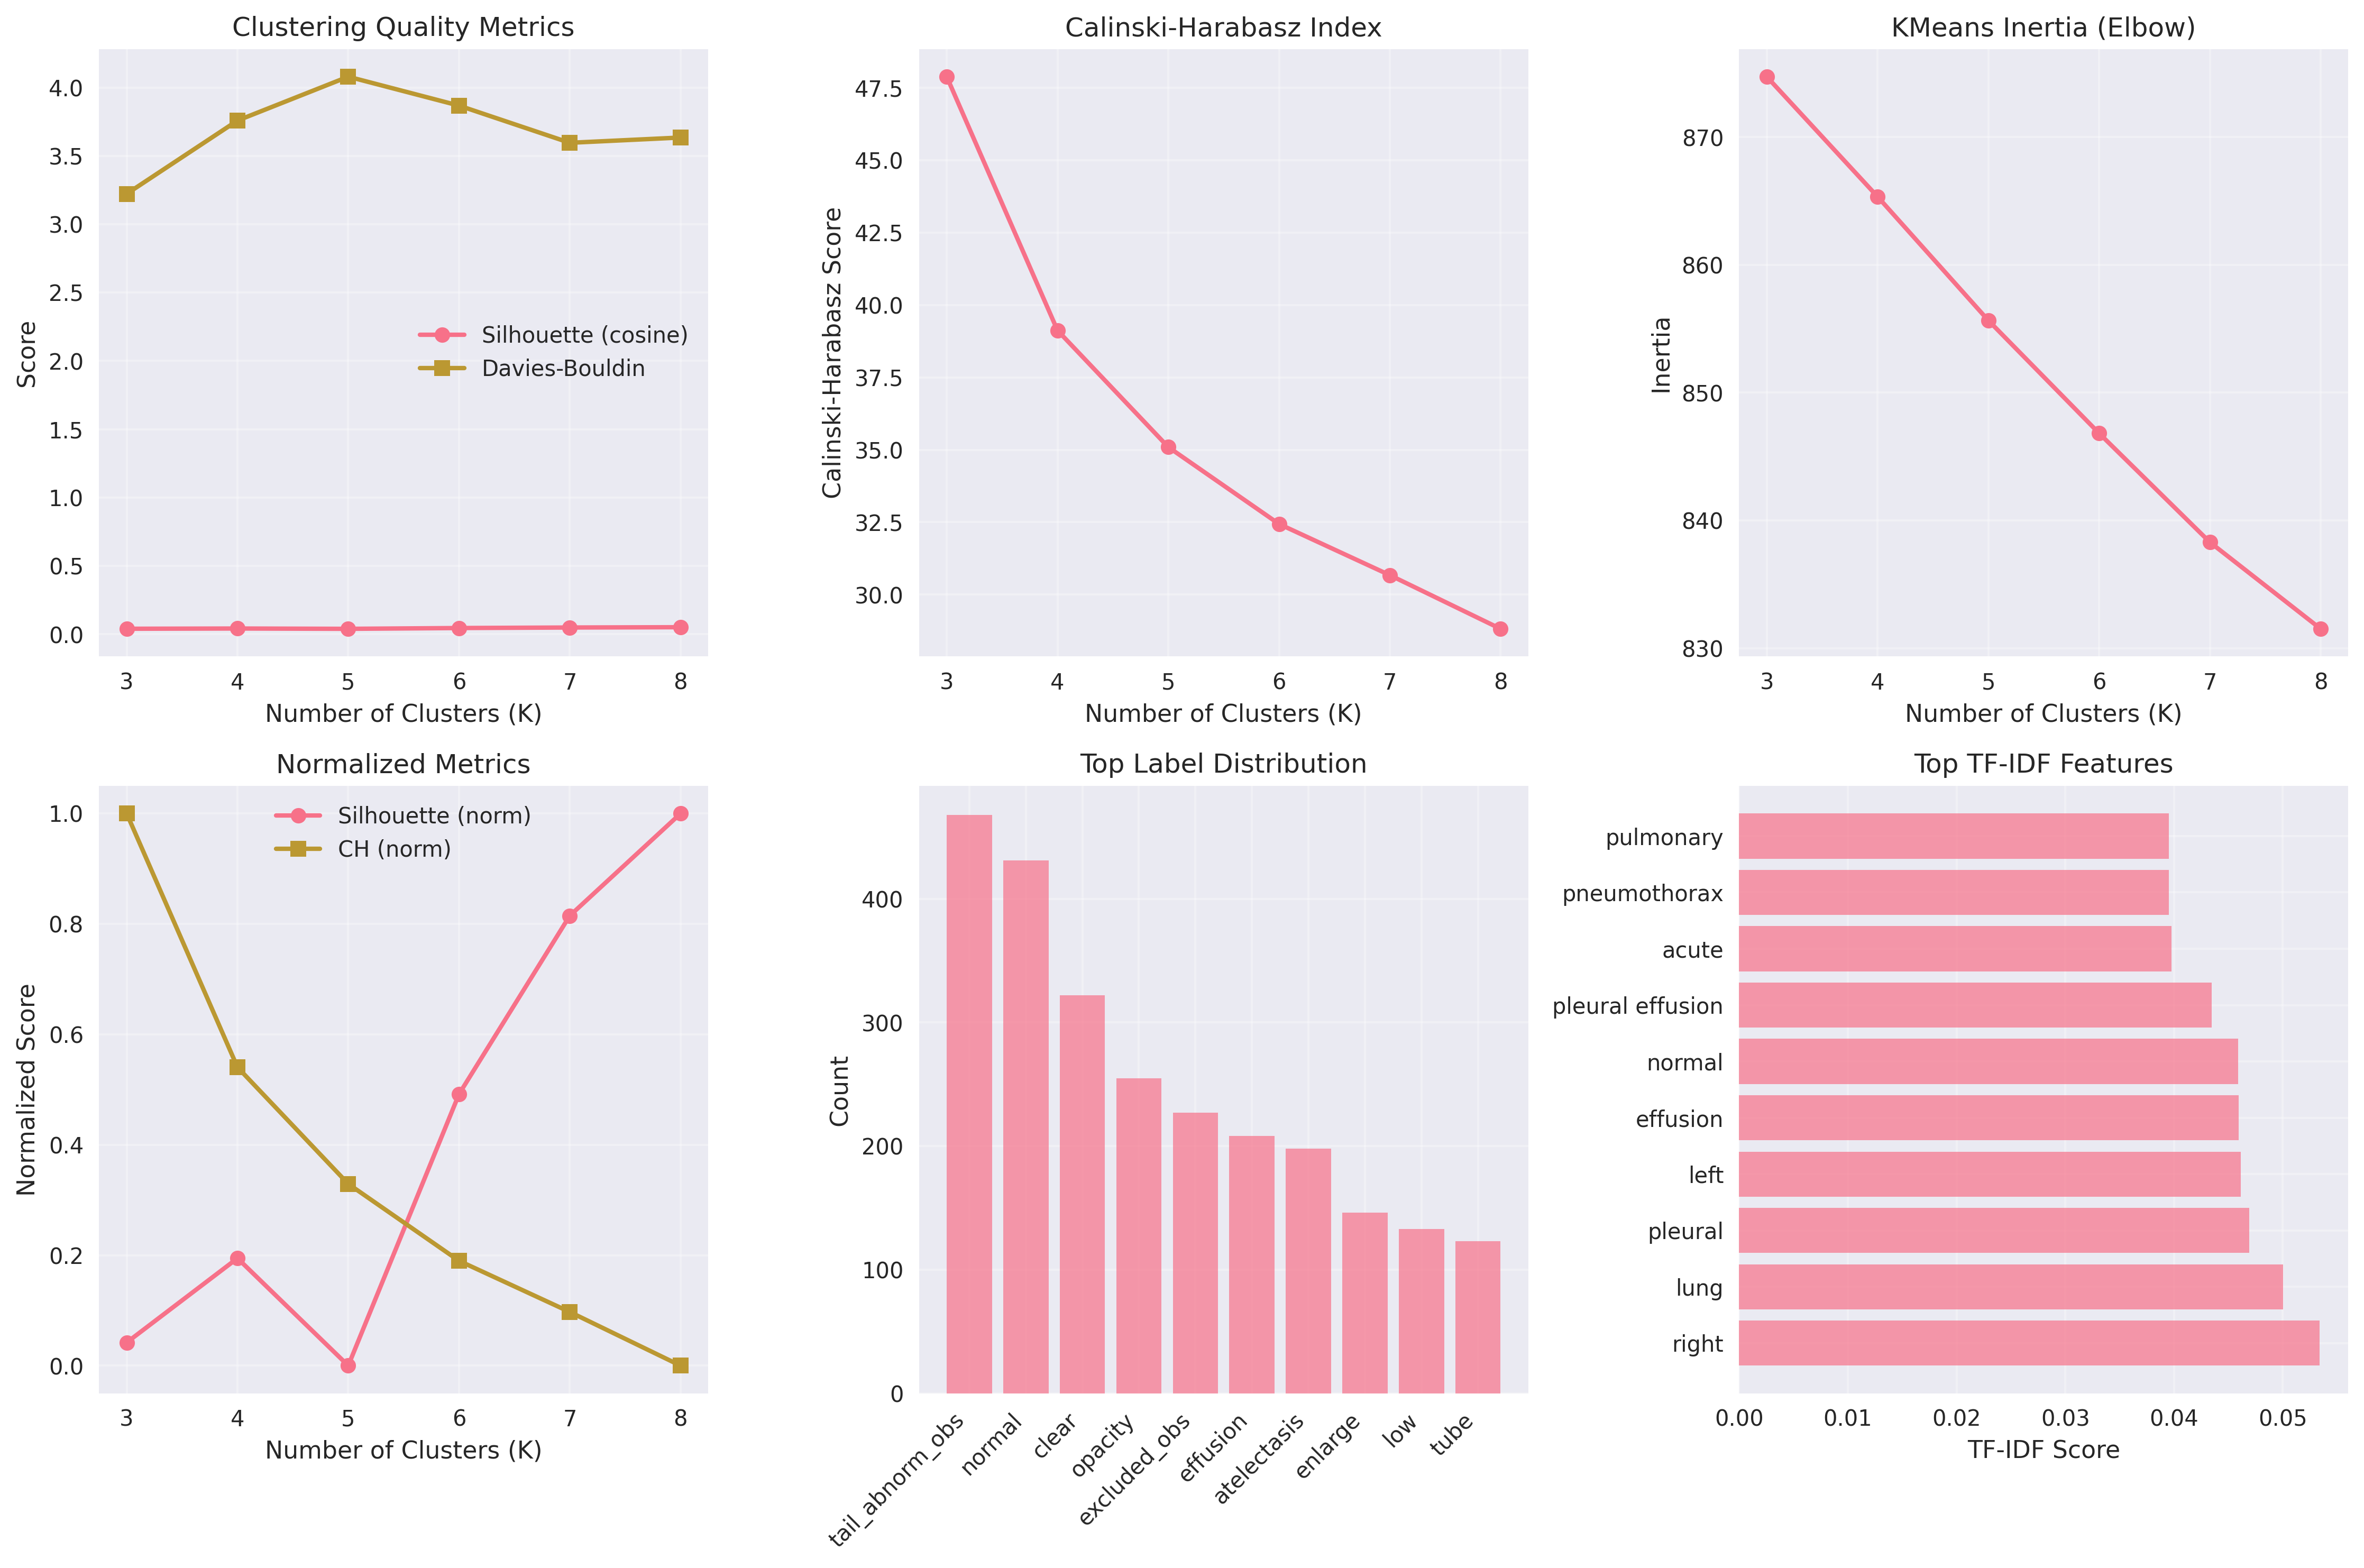

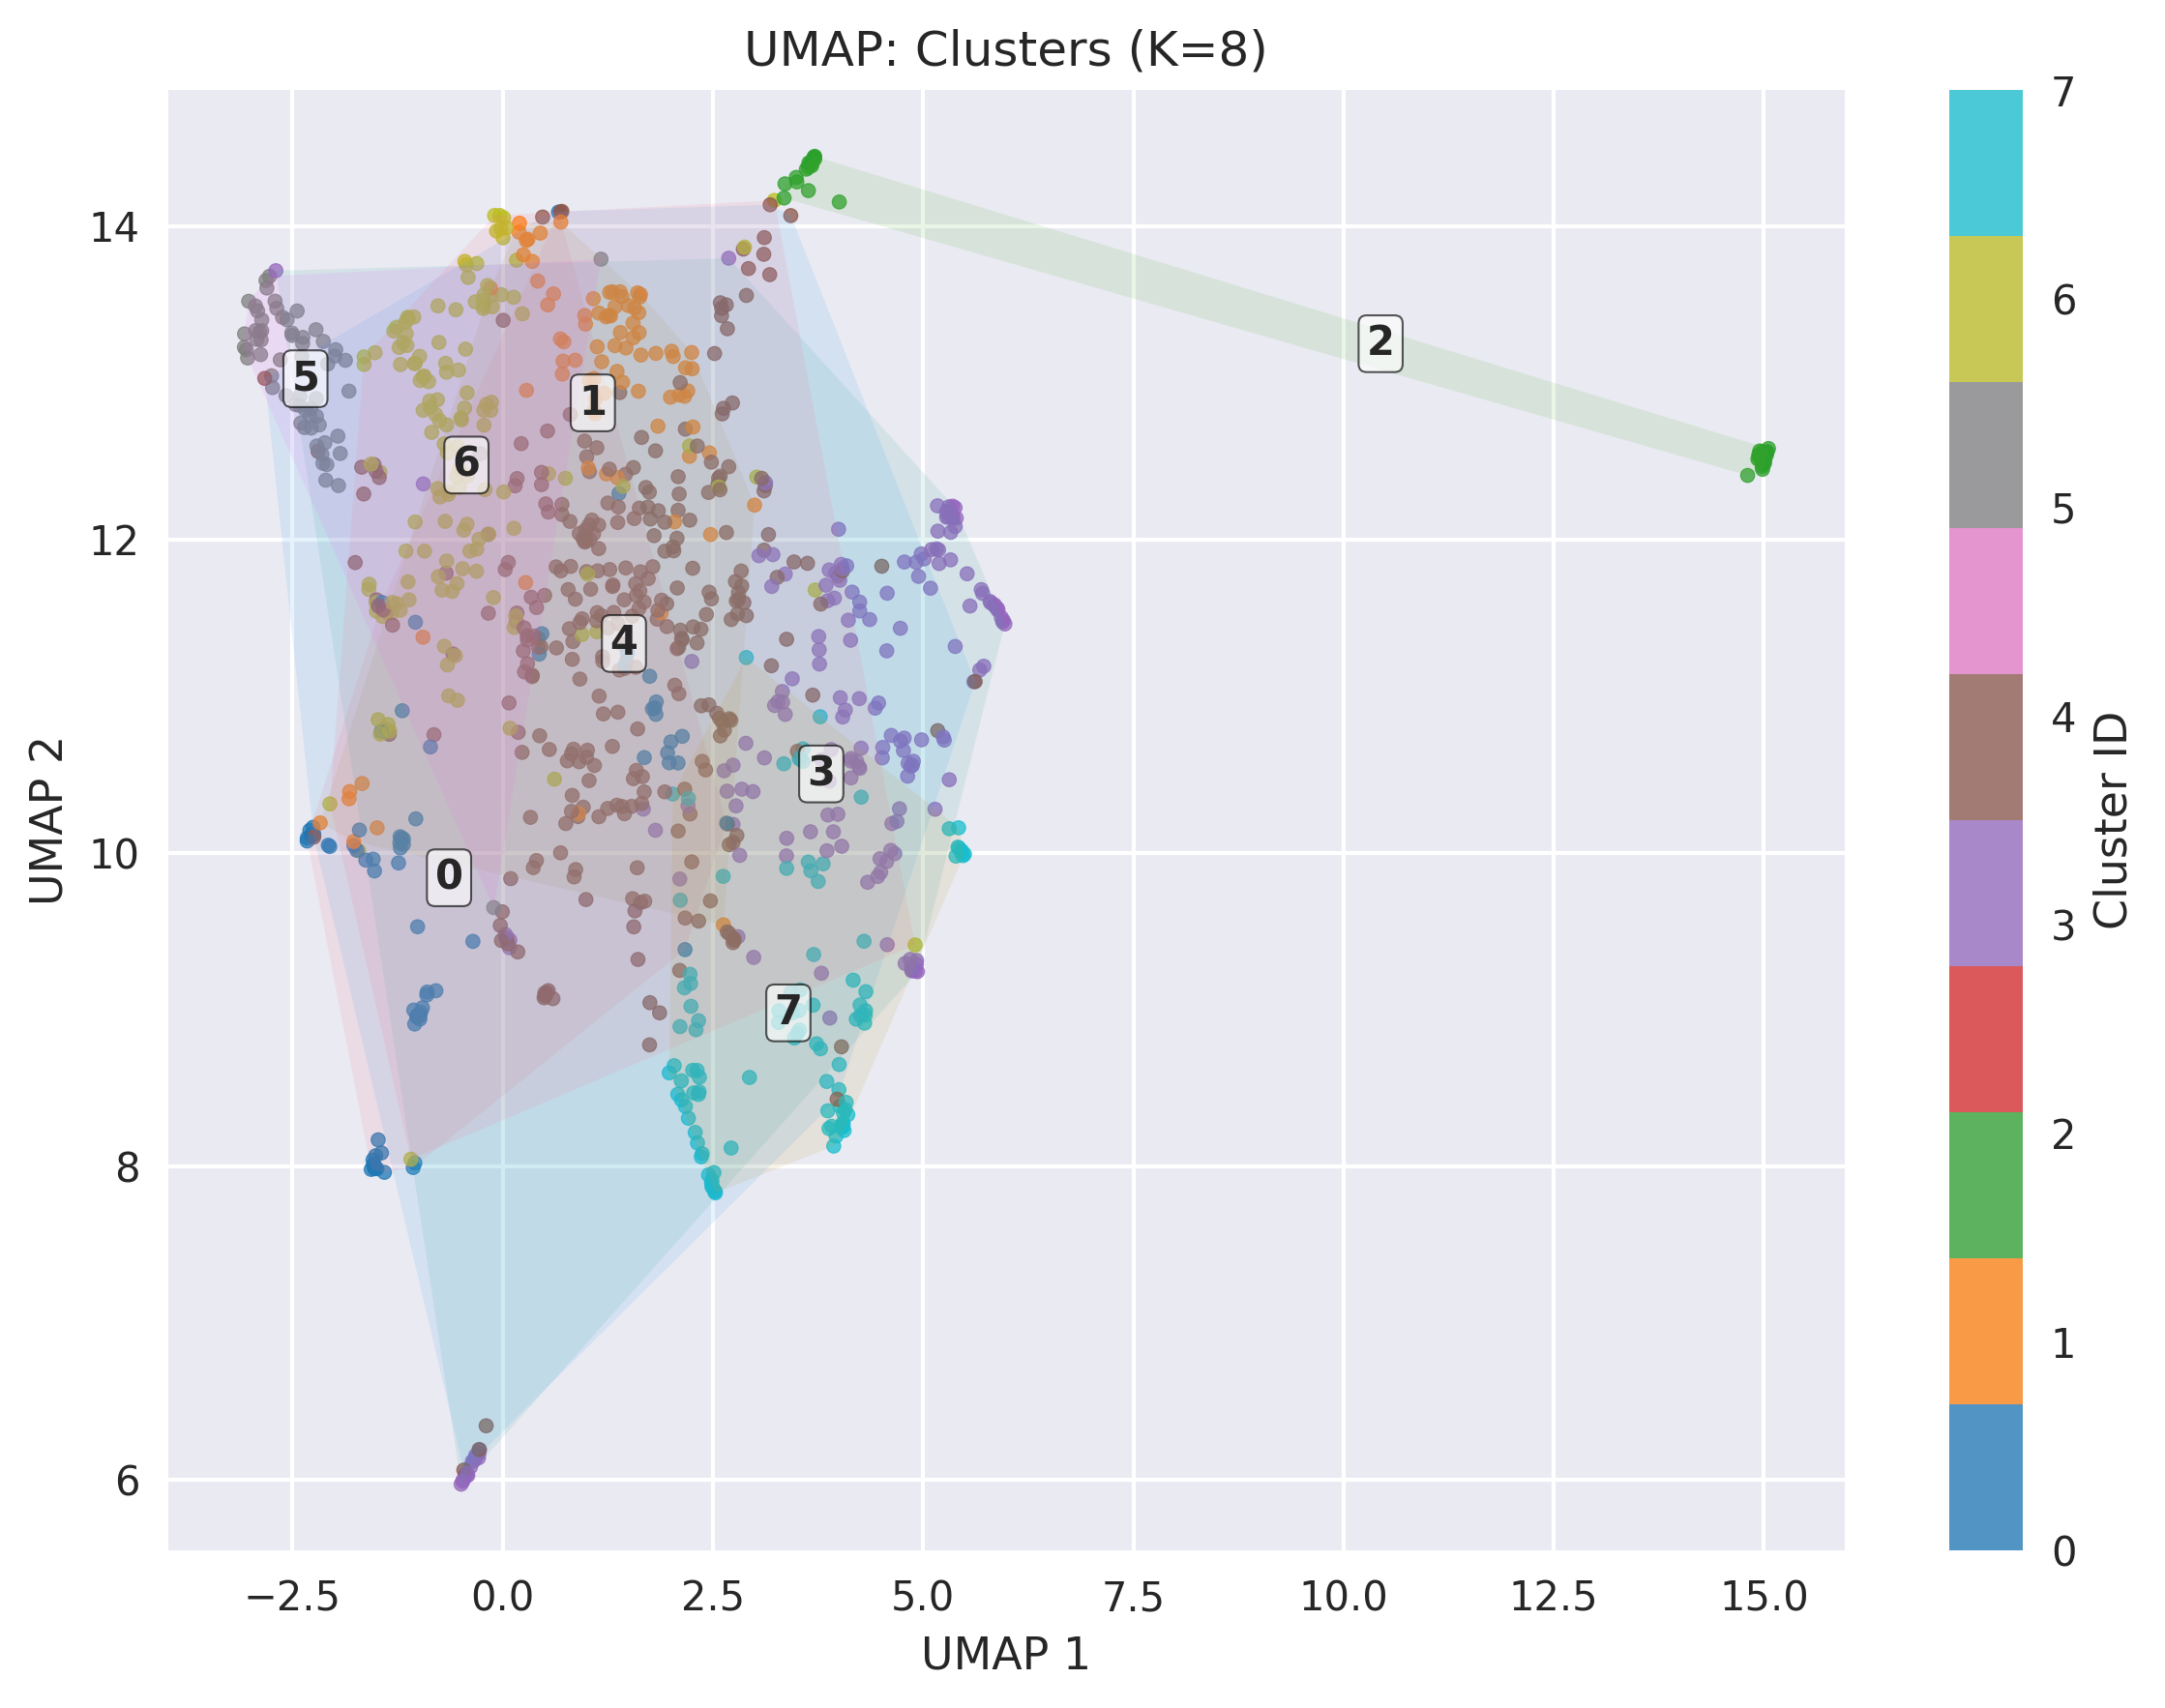

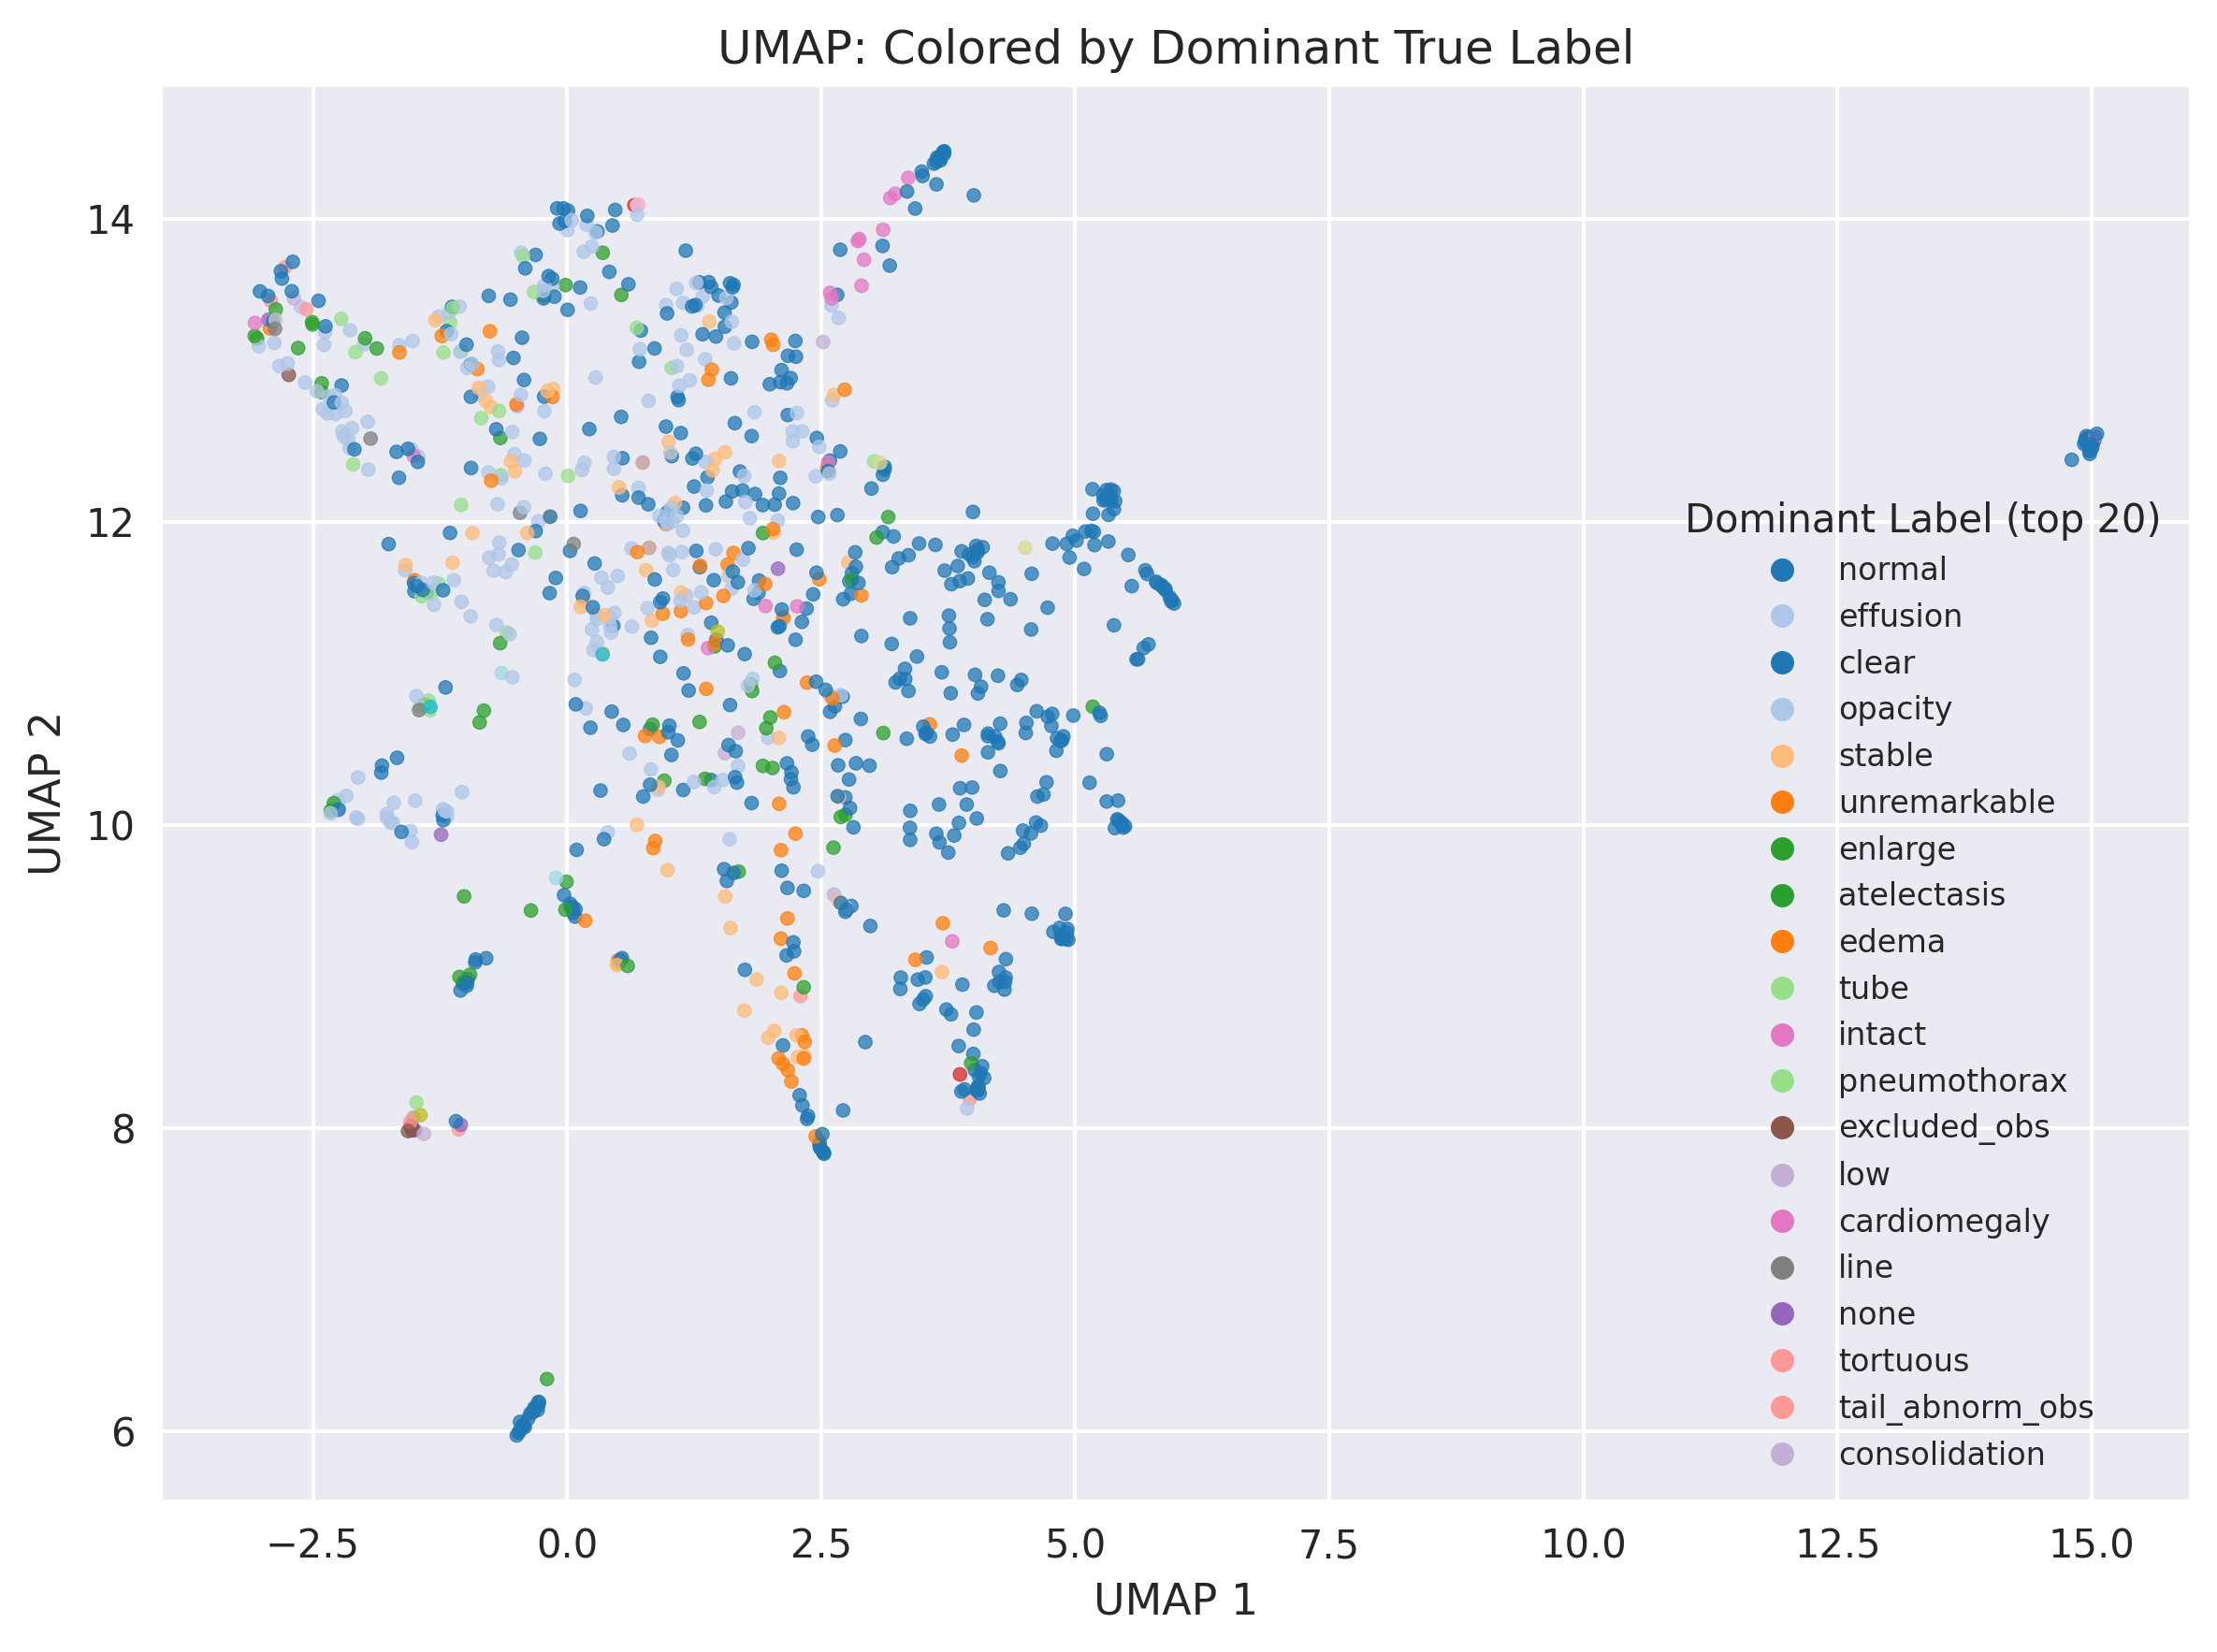

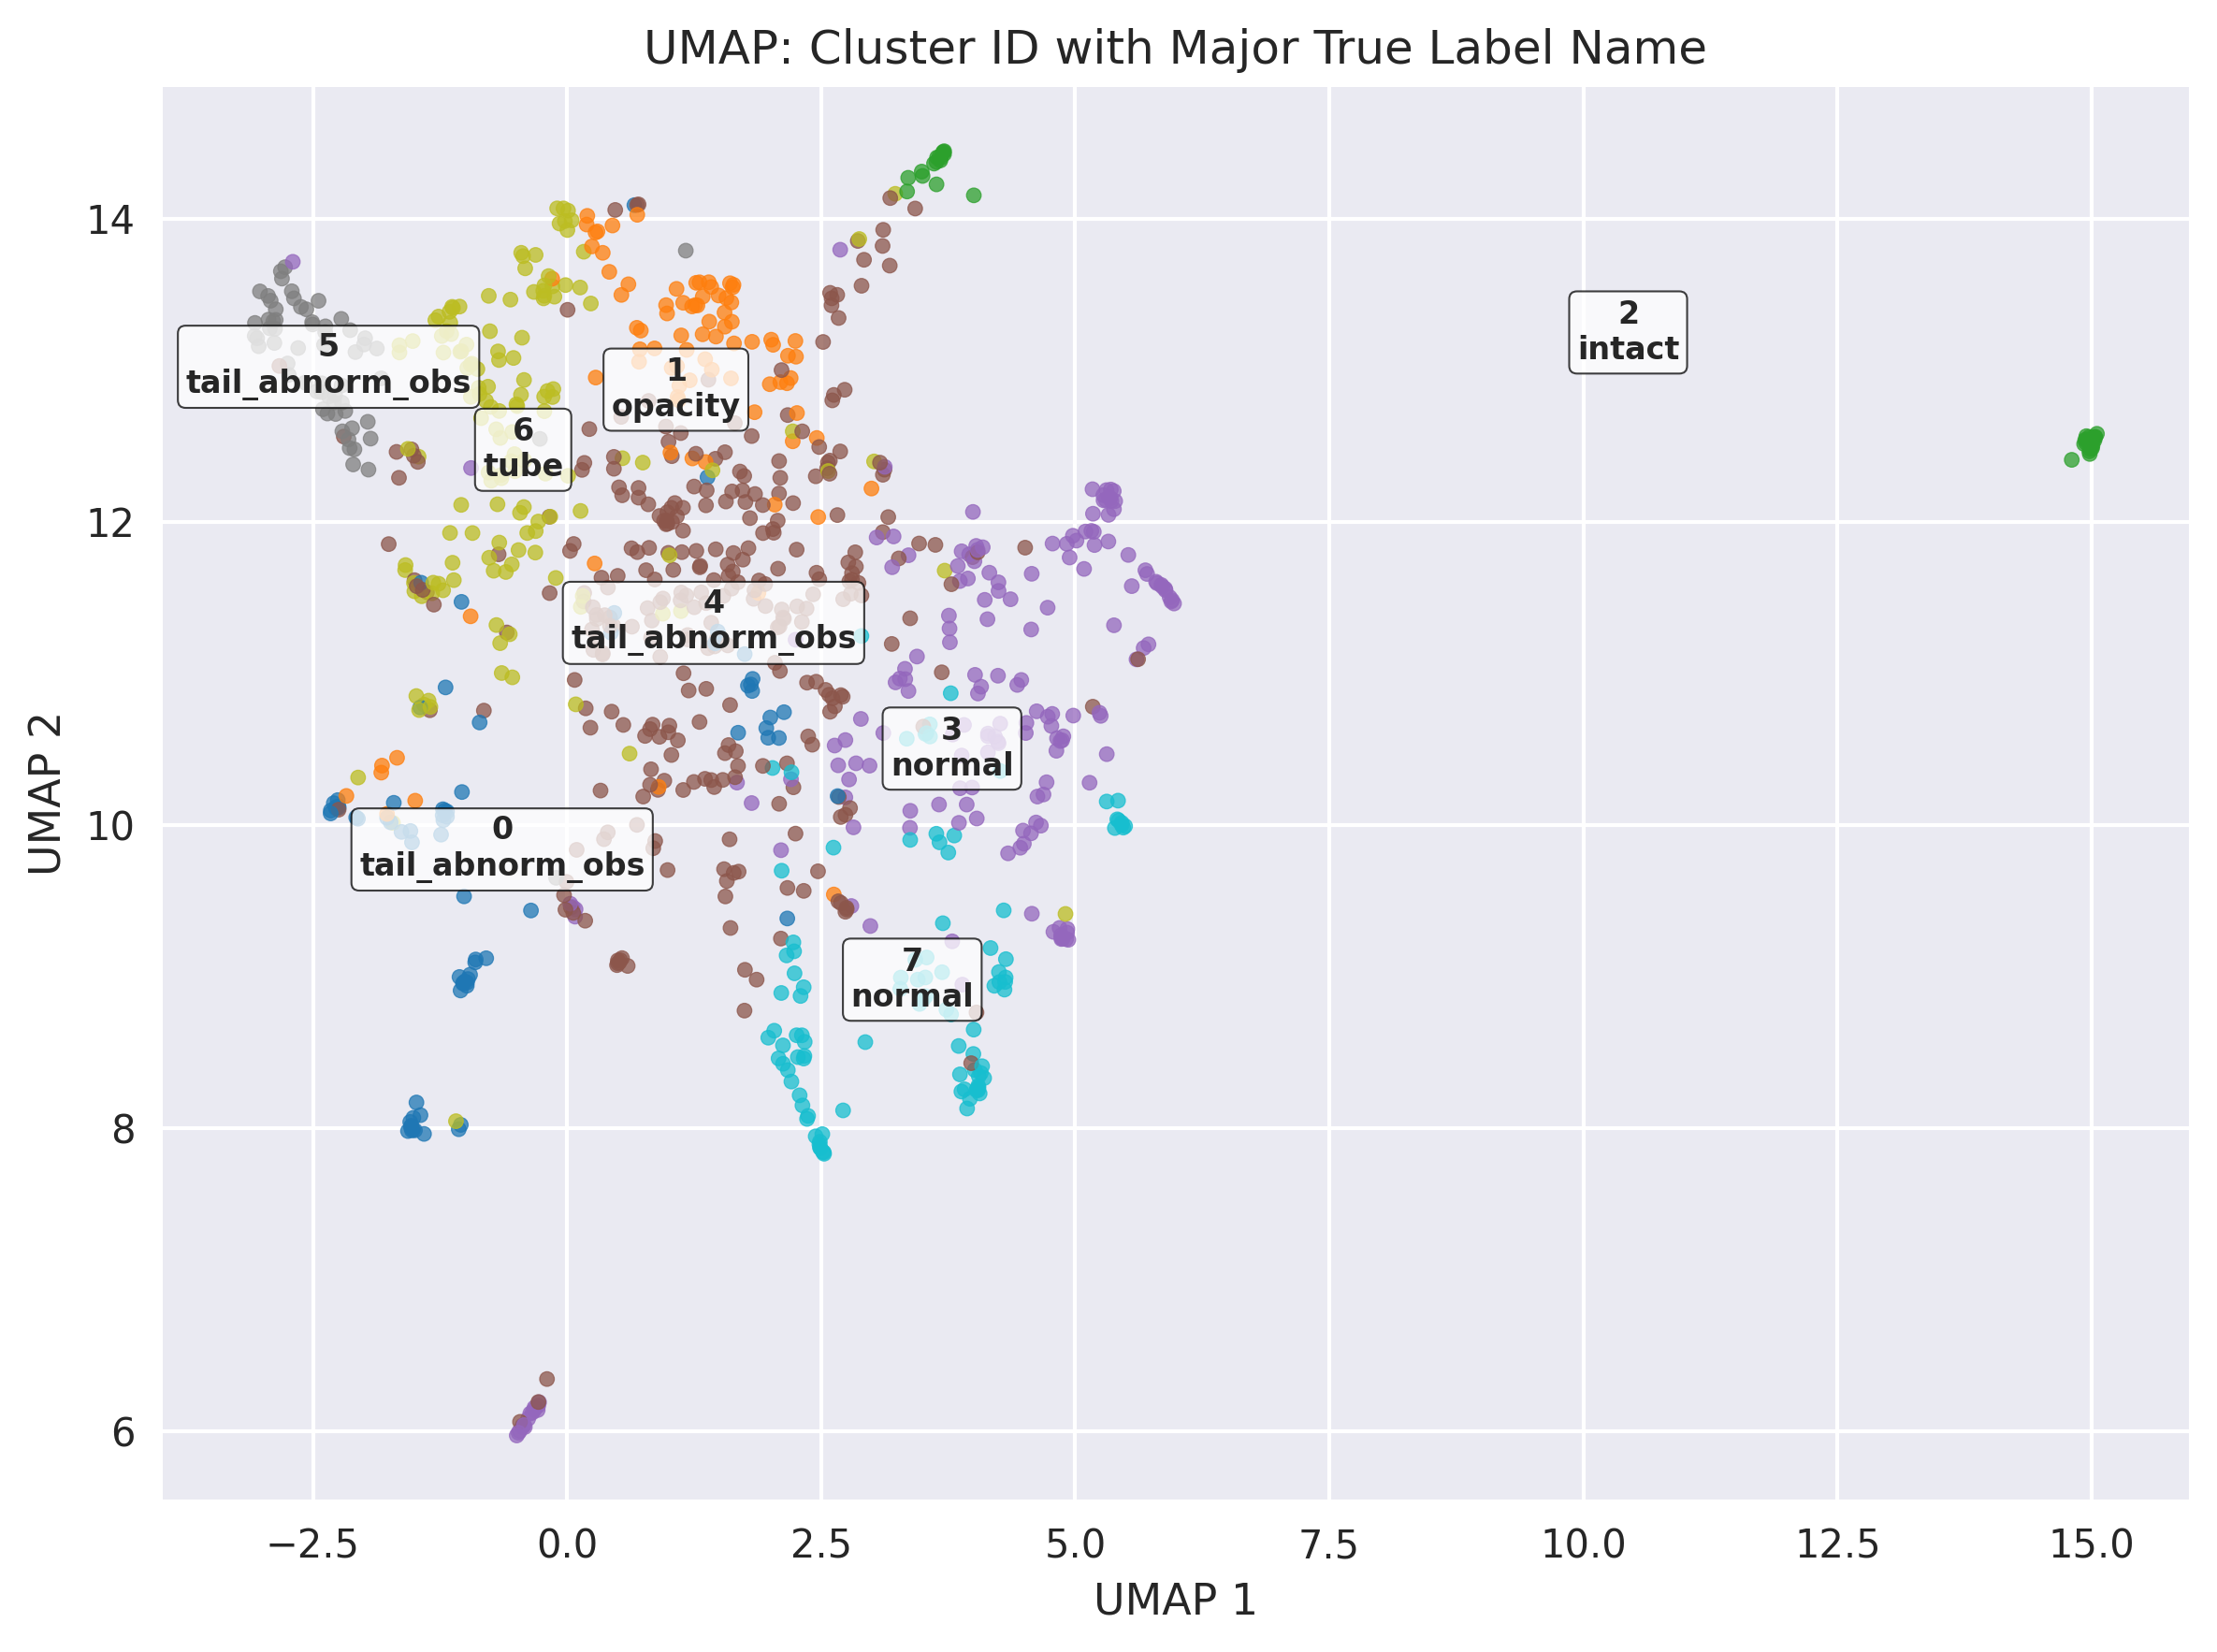

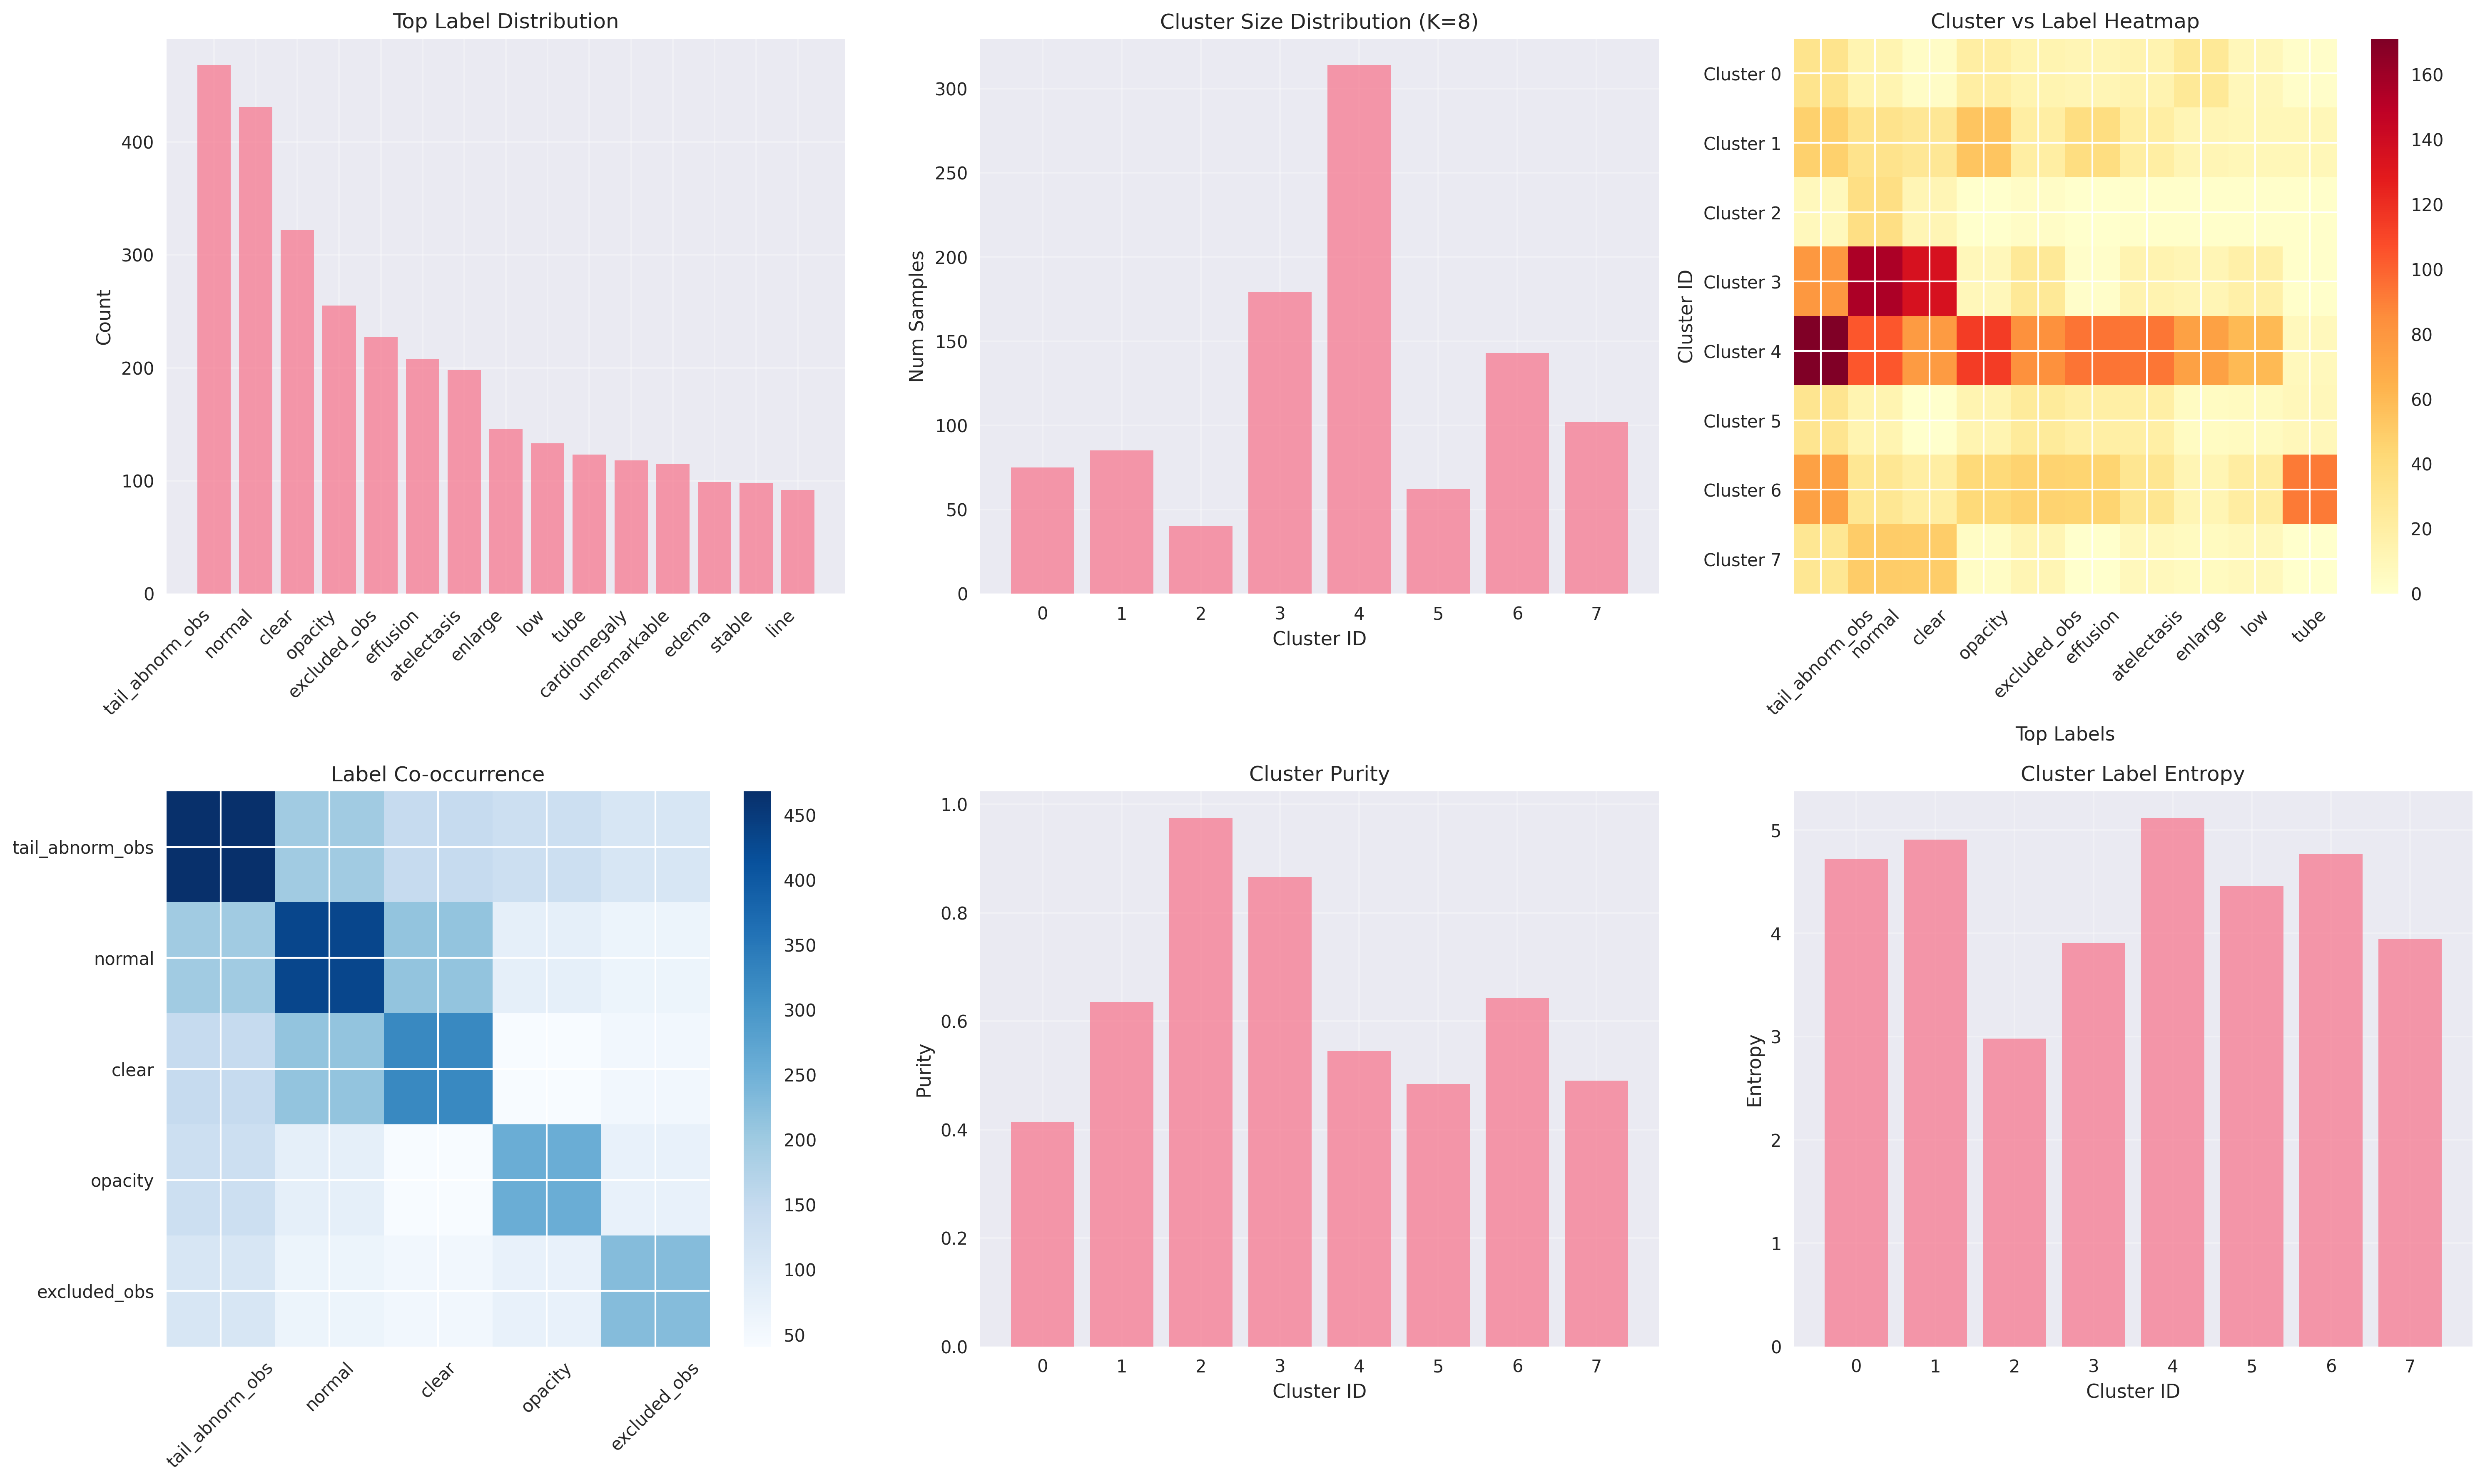

In [26]:
from IPython.display import display, Image

pics = [
    "results/clustering_quality.png",
    "results/umap_clusters.png",
    "results/umap_labels.png",
    "results/umap_cluster_label_match.png",
    "results/label_analysis.png",
]

for p in pics:
    try:
        display(Image(filename=p))
    except Exception as e:
        print("Missing:", p, e)
